<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/SocioenvironmentalGeometry/code/ConceptGeo_AnalysisPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concept Geometry analysis pipeline
For Nature Communication Psychology manuscript: <br>
Authors: <b>Roberto Vargas; Timothy Verstynen </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
Acknowledgements: <b>Nahom Mossazghi</b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Regression predicting pair edged using: <i>Race; Gender; Income; Age; NewsBias</i>
*   Mediation analysis:


<br>
<br>

In [ ]:
#@title Install dependancies [Check if commented out libraries are still needed otherwise delete]
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import scipy
from scipy import stats
from scipy.stats import t
from scipy.stats import entropy
from scipy.stats import norm
from collections import Counter
from itertools import combinations
from itertools import compress
import math
import statsmodels.formula.api as smf
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import networkx as nx
import requests
import os
import re
import warnings

In [ ]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM, Title, cbarLab):
    '''
    Restructure data into matrix structure heatmap
    '''
    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):
            if i == j:
#               Wmat[i,j] = np.NaN #avoid NaN because it interferes with subsequent analyses
                Wmat[i,j] = 7 #Max value on PRaM
            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1

    if PlotHM == 1:
      ax = plt.gca()
      im = ax.imshow(Wmat, cmap = 'RdBu', vmin=-7, vmax=7)
      cbar = ax.figure.colorbar(im, ax = ax, shrink=0.7)
      cbar.ax.set_ylabel(cbarLab, rotation = -90, va = "bottom", fontsize=15)
      cbar.ax.tick_params(labelsize=15)
      ax.set_xticks(np.arange(Wmat.shape[1]), labels = words, size=15)
      ax.set_yticks(np.arange(Wmat.shape[0]), labels = words, size=15)
      ax.tick_params(top = True, bottom = False, labeltop = True, labelbottom = False)
      plt.setp(ax.get_xticklabels(), rotation = -45, ha = "right", rotation_mode = "anchor", size=15)
      #ax.spines[:].set_visible(False)
      ax.set_xticks(np.arange(Wmat.shape[1] + 1) - 0.5, minor = True)
      ax.set_yticks(np.arange(Wmat.shape[0] + 1) - 0.5, minor = True)
      ax.grid(which = "minor", color = "black", linestyle = '-', linewidth = 1)
      ax.tick_params(which =  "minor", bottom = False, left = False)
      ax.set_title(Title)
      plt.show()
    return Wmat

def item_randperm(nItems, nperm):
    # Generate perm random permutations; In the future define a seed for replication
    return np.array([np.random.permutation(nItems) for _ in range(nperm)], dtype=int)

def mean_confidence_interval(data, confidence):
    # Generate confidence interval around a mean
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a) #compute SEM
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1) #Multiply the SEM with critical value 95%; two-tailed
    return m, m-h, m+h, h

def cit_difference(tstat, df, confidence):
    # Critical t-value for the desired confidence level
    t_critical = t.ppf((1 + confidence) / 2, df)

    # Confidence interval for the t-statistic
    ci_lower = tstat - t_critical
    ci_upper = tstat + t_critical

    return ci_lower, ci_upper

def r_CI(r,n,ci):
  confidence_level = ci # ex 0.95 confidence
  z = 0.5 * np.log((1 + r) / (1 - r))   # apply fischers r to z-transformation to control for nonnormality of r
  se_z = 1 / np.sqrt(n - 3)  # Standard error of z
  z_critical = norm.ppf((1 + confidence_level) / 2)

  z_lower = z - z_critical * se_z
  z_upper = z + z_critical * se_z

  # Transform back to r-space
  r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
  r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

  return r_lower, r_upper

def perm_meanDiff(x1,x2):

  observed_diff = np.mean(x1) - np.mean(x2)
  combined = np.concatenate([x1, x2])
  n_permutations = 10000
  n_x1 = len(x1)

  # Permutation test
  perm_diffs = []
  for _ in range(n_permutations):
      np.random.shuffle(combined)
      perm_x1 = combined[:n_x1]
      perm_x2 = combined[n_x1:]
      perm_diffs.append(np.mean(perm_x2) - np.mean(perm_x1))

  # Calculate p-value (two-tailed test)
  perm_diffs = np.array(perm_diffs)
  p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))

  # Results
  print(f"Observed Difference: {observed_diff:.4f}")
  print(f"P-value (Permutation Test): {p_value:.4f}")

  # Visualization of permutation distribution
  plt.hist(perm_diffs, bins=50, alpha=0.7, label="Permutation Distribution")
  plt.axvline(observed_diff, color='red', linestyle='--', label=f"Observed Difference ({observed_diff:.4f})")
  plt.axvline(-observed_diff, color='red', linestyle='--')
  plt.title("Permutation Test Distribution")
  plt.xlabel("Difference in Means")
  plt.ylabel("Frequency")
  plt.legend()
  plt.show()

  return observed_diff, p_value

def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure
    This analysis splits the data into 2 halves and averages the similarity structure.
    This analysis is repeated for the specified number of permutations.
    """
    # Precompute the random splits to avoid generating them repeatedly
    pSplit = item_randperm(dat.shape[1], perm)  # Assuming this function returns a NumPy array

    rho_values = np.zeros(perm)  # Preallocate for better memory management

    # Convert DataFrame to NumPy array for faster indexing
    dat_array = dat.to_numpy()

    half_size = dat_array.shape[1] // 2

    for p in range(perm):
        split_indices = pSplit[p]

        # Determine halves based on indices
        if dat_array.shape[1] % 2 == 0:  # Even number of columns
            first_half = dat_array[:, split_indices[:half_size]]
            second_half = dat_array[:, split_indices[half_size:]]
        else:  # Odd number of columns
            first_half = dat_array[:, split_indices[:half_size]]
            second_half = dat_array[:, split_indices[half_size + 1:]]

        # Compute mean along rows for both halves
        avg_first_half = first_half.mean(axis=1)
        avg_second_half = second_half.mean(axis=1)

        # Compute correlation between halves
        rho_values[p] = np.corrcoef(avg_first_half, avg_second_half)[0, 1]

    # Compute mean reliability across permutations
    rho_mean = rho_values.mean()

    return rho_mean

def regPairDiff(X, Y, perm):
    '''
    Predict pair differences among a X in Y
    X is vector or matrix of variables used to predict Y
    Y is a continuous vector
    perm is the number of permutations used to compare against the observed beta
    Dimensions of X and Y should all align
    '''

    # Generate the permutations
    pComb = item_randperm(X.shape[0],perm)

    # Generate constant
    con = np.ones(X.shape[0])
    con = con.reshape(con.shape[0], 1)

    # Estimate observed beta
    xModel = np.concatenate((con, X), axis=1)
    betaObs, _, _, _ = np.linalg.lstsq(xModel.astype('float'), Y, rcond=None)

    betaPerm = []

    for p in range(perm):
        pCombi = pComb.astype(int)
        yPerm = Y[pCombi[p,:]]
        bPerm, _, _, _ = np.linalg.lstsq(xModel.astype('float'), yPerm, rcond=None)
        betaPerm.append(bPerm)

    betaPerm = pd.DataFrame(betaPerm)

    pval =[]
    for b in range(len(betaObs)):
      if betaObs[b] > 0:
        nBbeyond =  len(np.where(np.array(betaPerm[b]) > betaObs[b])[0])
        pb = nBbeyond/perm
        pval.append(pb)
      elif betaObs[b] < 0:
        nBbeyond = len([x for x in np.array(betaPerm[b]) if x < betaObs[b]])
        pb = nBbeyond/perm
        pval.append(pb)

      else:
        raise ValueError('observed beta is exactly equal to 0')

    return betaObs, pval, betaPerm


def mediation(x, m, y):
  '''
  Predict pair differences among a X in Y and the extent which this effect is mediated by m
 	X is vector used to predict Y
  m is a mediator
 	Y is a continuous vector
  '''
  import statsmodels.api as sm
  #Test effect of X on Y
  X = pd.DataFrame({'Intercept':np.ones(len(x)),'X':x})
  lm1 = sm.OLS(y,X).fit()
  ec = lm1.params[1] # save total effect c to ec

  #Test effect of X on M
  lm2 = sm.OLS(m,X).fit()
  ea = lm2.params[1] # Save the effect of X on M, a, to ea
  sea = lm2.bse[1]

  #Test effect of X and M on Y
  X['M'] = m
  lm3 = sm.OLS(y,X).fit()
  ecq,eb = lm3.params[1:3]
  seb = lm3.bse[2]

  toteff = ec # Total effect
  XM = ea #coef from x to m
  MY = eb #coef from m to y
  XMse = sea #standard error from x to m
  MYse = seb #standard error from m to y
  medeff = ea*eb #Indirect mediated effect
  direff = ecq #Direct effect
  sumeff = medeff + direff #sum of effect
  return toteff, medeff, direff, sumeff, XM, MY, XMse, MYse


def mediationPerm(x, m, y, perm):
  import statsmodels.api as sm
  '''
  Predict pair differences among a X in Y and the extent which this effect is mediated by m
 	X is vector used to predict Y
  m is a mediator
 	Y is a continuous vector
 	perm is the number of permutations used to compare against the observed beta
  Dimensions of X, m, and Y should all align
  '''
  pComb = item_randperm(len(X),perm)
  toteff_obs, medeff_obs, direff_obs, sumeff_obs, XM_obs, MY_obs, XMse_obs, MYse_obs = mediation(x, m, y)
  t_obs, _ = sobel_test(XM_obs, MY_obs, XMse_obs, MYse_obs)

  toteff_perm = []
  medeff_perm = []
  direff_perm = []
  sumeff_perm = []
  medt_perm = []

  for p in range(perm):
      pCombi = pComb.astype(int)
      yPerm = y[pCombi[p,:]]
      toteff, medeff, direff, sumeff, XM, MY, XMse, MYse = mediation(x, m, yPerm)
      t_perm, _ = sobel_test(XM, MY, XMse, MYse)
      toteff_perm.append(toteff)
      medeff_perm.append(medeff)
      direff_perm.append(direff)
      sumeff_perm.append(sumeff)
      medt_perm.append(t_perm)

  pval_tot = []
  pval_med = []
  pval_dir = []
  pval_sum = []
  pval_sobelT = []

  #Determine sig for total effect
  if toteff_obs > 0:
    nBbeyond =  len(np.where(toteff_perm > toteff_obs)[0])
    pb = nBbeyond/perm
    pval_tot.append(pb)
  elif toteff_obs < 0:
    nBbeyond = len([x for x in toteff_perm if x < toteff_obs])
    pb = nBbeyond/perm
    pval_tot.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for med effect
  if medeff_obs > 0:
    nBbeyond =  len(np.where(medeff_perm > medeff_obs)[0])
    pb = nBbeyond/perm
    pval_med.append(pb)
  elif medeff_obs < 0:
    nBbeyond = len([x for x in medeff_perm if x < medeff_obs])
    pb = nBbeyond/perm
    pval_med.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for dir effect
  if direff_obs > 0:
    nBbeyond =  len(np.where(np.array(direff_perm) > direff_obs)[0])
    pb = nBbeyond/perm
    pval_dir.append(pb)
  elif direff_obs < 0:
    nBbeyond = len([x for x in direff_perm if x < direff_obs])
    pb = nBbeyond/perm
    pval_dir.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for sum of effect
  if sumeff_obs > 0:
    nBbeyond =  len(np.where(sumeff_perm > sumeff_obs)[0])
    pb = nBbeyond/perm
    pval_sum.append(pb)
  elif sumeff_obs < 0:
    nBbeyond = len([x for x in sumeff_perm if x < sumeff_obs])
    pb = nBbeyond/perm
    pval_sum.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Test t effect from Sobel test
  if t_obs > 0:
    nTbeyond = len(np.where(medt_perm > t_obs)[0])
    pt = nTbeyond/perm
    pval_sobelT.append(pt)
  elif t_obs < 0:
    nTbeyond = len([x for x in medt_perm if x < t_obs])
    pt = nTbeyond/perm
    pval_sobelT.append(pt)
  else:
    raise ValueError('observed t is exactly equal to 0')

  ObsEff = pd.DataFrame({'TotEff':toteff_obs,'MedEff':medeff_obs, 'DirEff':direff_obs, 'SumEff':sumeff_obs, 'SobelT':t_obs},index=[0])
  pval = pd.DataFrame({'Totpval':pval_tot,'Medpval':pval_med, 'Dirpval':pval_dir, 'Sumpval':pval_sum, 'SobelTpval':pval_sobelT},index=[0])
  return ObsEff, pval


def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation

    Args:
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns:
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''

    SE = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    t = (a*b) / SE
    n = 100000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval


def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  1.0 / (1.0 + numpy.exp(-a * (x-b))) + Offset


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) # search bounds for a
    parameterBounds.append([minX, maxX]) # search bounds for b
    parameterBounds.append([0.0, maxY]) # search bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

In [ ]:
#@title Load data, Clean dataframes, and mask out participants who didn't complete all parts of the study session
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/SocioenvironmentalGeometry/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'data/demographic.csv', header=1)
datPRaM = pd.read_csv (path + 'data/df_taskPRaM.csv', header=0)
pairLab = pd.read_csv (path + 'data/PRaM_pairLabels.csv', header=None)
news = pd.read_csv (path + 'data/df_News_coded.csv', header=1)

#remove misc row and incomplete sessions
datDemo = datDemo.drop(labels=0, axis=0)
datDemo = datDemo.reset_index(drop=True)
datDemo['Question Key'] = [sub[: -2] for sub in datDemo['Question Key']]
datPRaM = datPRaM.drop(['Participant Private ID'], axis=1)
datPRaM = datPRaM.reset_index(drop=True)
news = news.drop(labels=0, axis=0)
news = news.reset_index(drop=True)

#Identify participants who did not complete all measures
lst1 = datDemo['Question Key']
lst2 = news['Question Key']
exPart = list(set(lst1) - set(lst2))
mask = datDemo['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
datDemo = datDemo[~mask]
datPRaM = datPRaM[~mask]

#reset index just in case
datDemo = datDemo.reset_index(drop=True)
datPRaM = datPRaM.reset_index(drop=True)
news = news.reset_index(drop=True)

#Sort pairs accoring to prefered combination
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]

#Standardize order and Left-right position of concepts: generate new sorted data frame
PairLabel = []    #AB order of concepts for each of interpretations
allPairIdx = []   #index orders are saved as list
for i in range(len(combinations_list)):

  PairLabelAB = combinations_list[i][0] + '-' + combinations_list[i][1]
  PairLabelBA = combinations_list[i][1] + '-' + combinations_list[i][0]

  if PairLabelAB in datPRaM:
    PairLabeli = PairLabelAB
  elif PairLabelBA in datPRaM:
    PairLabeli = PairLabelBA
  else:
    print('Error: The concept pair in the combination list does not exist in dataset')

  pairIdx = datPRaM.columns.get_loc(PairLabeli)
  PairLabel.append(PairLabelAB) #For each of interpretation of future vizualizations we always use the AB structure
  allPairIdx.append(pairIdx)

# Pair label rating
datPRaM_conSort = datPRaM.iloc[:,allPairIdx]
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, PairLabel)))
PairLabel = pd.DataFrame(PairLabel)

In [ ]:
datDemo['partDegree'].value_counts()

,count
partDegree,
Bachelors,32
BA,29
High School Diploma,22
Bachelor's,21
High School,20
...,...
Master Degree,1
Master Civil Engineering,1
doctoral,1


In [ ]:
#@title Compute left/right simulus presentation statistics: smaller range means greater L/R simuli randomization
fullLeftList = [c for (c,z) in combinations_list]

wLeftPerc = []
for w in words:
  leftTally = [t for t in fullLeftList if t == w]
  wLeftPerc.append((len(leftTally)/(len(words)-1))*100)
print('mean probability of left position = ', np.mean(wLeftPerc))
print('The probabilities range from', min(wLeftPerc), 'to', max(wLeftPerc))

mean probability of left position =  50.0
The probabilities range from 0.0 to 100.0


In [95]:
#@title Subset participants by those who have complete data for analyzed variables
#Isolate Race variable
raceCol = datDemo.columns.get_loc('raceEth_v2')
bIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('Black or African American')].index
wIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('White')].index
IDCol = datDemo.columns.get_loc('Question Key')
bID = datDemo.iloc[bIndx,IDCol]
blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])

#Isolate PRaM variable
bPRaM = datPRaM_conSort.iloc[bIndx,:]
wPRaM = datPRaM_conSort.iloc[wIndx,:]
PRaM = np.concatenate([bPRaM, wPRaM])

#Isolate Zip variable
zipBornCol = datDemo.columns.get_loc('zipborn')
bZipBorn = datDemo.iloc[bIndx,zipBornCol]
wZipBorn = datDemo.iloc[wIndx,zipBornCol]
zipBorn = np.concatenate([bZipBorn, wZipBorn])

zip10yCol = datDemo.columns.get_loc('response-3')
bZip10y = datDemo.iloc[bIndx,zip10yCol]
wZip10y = datDemo.iloc[wIndx,zip10yCol]
zip10y = np.concatenate([bZip10y, wZip10y])

zipNowCol= datDemo.columns.get_loc('zipnow')
bZipNow = datDemo.iloc[bIndx,zipNowCol]
wZipNow = datDemo.iloc[wIndx,zipNowCol]
zipNow = np.concatenate([bZipNow, wZipNow])

# Isolate Age variable and subset sample by race
ageCol = datDemo.columns.get_loc('age')
bAge = datDemo.iloc[bIndx,ageCol]
wAge = datDemo.iloc[wIndx,ageCol]
bAge = bAge.replace(1984, 38) #Convert participant birth year into ago
Age = np.concatenate([bAge, wAge])

# Isolate Income variable and subset sample by race
incCol = datDemo.columns.get_loc('Income')
bIncome = datDemo.iloc[bIndx,incCol]
wIncome = datDemo.iloc[wIndx,incCol]
Income = np.concatenate([bIncome, wIncome])
Income = pd.Series(Income)

# Isolate Education variable and subset sample by race
EduCol = datDemo.columns.get_loc('partDegree')
bEducation = datDemo.iloc[bIndx, EduCol]
wEducation = datDemo.iloc[wIndx, EduCol]
Education = pd.Series(np.concatenate([bEducation, wEducation]))

# Isolate Gender variable and create concatonated vector
gendCol = datDemo.columns.get_loc('gender')
bGender = datDemo.iloc[bIndx,gendCol]
wGender = datDemo.iloc[wIndx,gendCol]
Gender = np.concatenate([bGender, wGender])
Gender = pd.Series(Gender)

#Homogenize Gender responses to F and M and remove genders with insufficient representation
remIndx = Gender.str.contains(pat = 'non', case=False) | Gender.str.contains(pat = 'Gen', case=False)
Gender.loc[remIndx]= 'R'
femIndx = Gender.str.contains(pat = 'f',case=False) | Gender.str.contains(pat = 'w',case=False)
Gender.loc[femIndx]= 'F'
maleIndx = Gender.str.contains(pat = 'an',case=False) | Gender.str.contains(pat = 'al',case=False)
Gender.loc[maleIndx]= 'M'

#Isolate News bias and subset sample by race
newsbiasCol = news.columns.get_loc('avgBias')
bNewsBias = news.iloc[bIndx,newsbiasCol]
wNewsBias = news.iloc[wIndx,newsbiasCol]
NewsBias = np.concatenate([bNewsBias, wNewsBias])
NewsBias = pd.Series(NewsBias)

#Remove underrepesented gender identities (i.e, non-bianary)
PRaM_nG = PRaM[~remIndx]
Gender_nG = Gender[~remIndx]
Income_nG = Income[~remIndx]
Age_nG = Age[~remIndx]
NewsBias_nG = NewsBias[~remIndx]
zipBorn_nG = zipBorn[~remIndx]
zip10y_nG = zip10y[~remIndx]
zipNow_nG = zipNow[~remIndx]
blackCode_nG = blackCode[~remIndx]
remIndx = remIndx.reset_index(drop=True)
Education_nG = Education[~remIndx].reset_index(drop=True)

#Remove participants who only consumed algorithmic news sources
remIdxNBias= NewsBias_nG.str.contains(pat = 'x', case=False)
PRaM_nGnANB = PRaM_nG[~remIdxNBias]
Gender_nGnANB = Gender_nG[~remIdxNBias]
Income_nGnANB = Income_nG[~remIdxNBias]
Age_nGnANB = Age_nG[~remIdxNBias]
NewsBias_nGnANB = NewsBias_nG[~remIdxNBias]
NewsBias_nGnANB = NewsBias_nGnANB.astype('float')
zipBorn_nGnANB = zipBorn_nG[~remIdxNBias]
zip10y_nGnANB = zip10y_nG[~remIdxNBias]
zipNow_nGnANB = zipNow_nG[~remIdxNBias]
blackCode_nGnANB = blackCode_nG[~remIdxNBias]
remIdxNBias = remIdxNBias.reset_index(drop=True)
Education_nGnANB = Education_nG[~remIdxNBias].reset_index(drop=True)

#Convert Gender to dummy coded variable [Female = 1; Male = 0]
FInd = Gender_nGnANB.str.contains('F')
MInd = Gender_nGnANB.str.contains('M')
Gender_nGnANB.loc[FInd] = 1
Gender_nGnANB.loc[MInd] = 0
Gender_nGnANB = Gender_nGnANB



# Income ordinal Sclae
customSort = {
    'Less than $12500': 0,
    '$12501-$22500': 1,
    '$22501-$42500': 2,
    '$42501-$80000': 3,
    'More than $80000': 4
}
Income_nGnANB['Income_nGnANB_Ordinal'] = Income_nGnANB.map(customSort).sort_values()

# Education Ordinal Scale
customSort_edu = {
    'No highschool': 0,
    'Elementry School': 0,
    'Some highschool': 1,
    'less than high school': 1,
    'Highschool Degree': 2,
    'High School Diploma': 2,
    'high school': 2,
    'hs diploma': 2,
    'GED': 2,
    'Some College': 3,
    'hoigh school/some college': 3,
    '1 year of college': 3,
    'College': 4,
    '4 year degree': 4,
    '4 year': 4,
    'college degree': 4,
    'High School grad, some college': 4,
    'Associates Degree': 5,
    'Associates': 5,
    'associate': 5,
    'AA':5,
    'aa':5,
    'Ass degree': 5,
    'Technicial Certifiicate': 5,
    'Associate of Arts': 5,
    'vocational training': 5,
    'bachelors': 6,
    'Bachelors': 6,
    'Bachelor' : 6,
    'Bachelors -college graduated':6,
    'BA': 6,
    'B.A.': 6,
    'AB': 6,
    'ba degree': 6,
    'ba': 6,
    'bachelor of science': 6,
    'BSN': 6,
    'BS': 6,
    'B.E': 6,
    'Military': 6,
    'Bachelor of Arts': 6,
    'BS in Medical Technology': 6,
    'Masters Degree': 7,
    'Masters degree': 7,
    'MFA': 7,
    'MCA': 7,
    'M.A': 7,
    'MSW +2 (LCSW, Professional license)':7,
    'masters': 7,
    'Masters':7,
    'MASTERDEGREE':7,
    'MD': 7,
    'MBC': 7,
    'MBA': 7,
    'Master Civil Engineering': 7,
    'Graduate degree': 7,
    'PhD': 8,
    'Doctorate': 8,
    'Doctor': 8,
    'MS Engineering': 7,
    'Doctorate Degree':8
}
Education_nGnANB = Education_nGnANB.to_frame(name='Education')
Education_nGnANB['Education_nGnANB_Ordinal'] = Education_nGnANB['Education'].map(customSort_edu).astype('Int64')


print(f'Sample of participant completing session = ', len(datDemo['Question Key']))
print(f'Of',len(datDemo['Question Key']), ',' ,(len(bIndx)+len(wIndx)), 'participants identified as non-Hispanic White(', len(wIndx),') or Black/AfricanAmerican(', len(bIndx),')')
print(f'of', (len(bIndx)+len(wIndx)), ',', len(Gender_nG), 'participants identified as Female(', sum(femIndx==1), ') or Male(', sum(maleIndx==1),')')
print(f'of the', len(Gender_nG), ',', len(NewsBias_nGnANB), 'participants consumed a non-algorithmic news source with measurable political bias.')
print(f'The final analyzed sample contains', len(NewsBias_nGnANB), 'participants!')

Sample of participant completing session =  585
Of 585 , 572 participants identified as non-Hispanic White( 294 ) or Black/AfricanAmerican( 278 )
of 572 , 567 participants identified as Female( 286 ) or Male( 281 )
of the 567 , 446 participants consumed a non-algorithmic news source with measurable political bias.
The final analyzed sample contains 446 participants!


The sample is 49.55 % Female and 50.45 % Male
The sample is 47.76 % Black and 52.24 % White
The number of White Males is: 114
The number of White Females is: 119
The number of Black Males is: 111
The number of Black Females is: 102
Mean age for sample: 40.56 ( SD = 12.43 )
Mean age for Black sample:  37.99
Mean age for White sample:  42.91


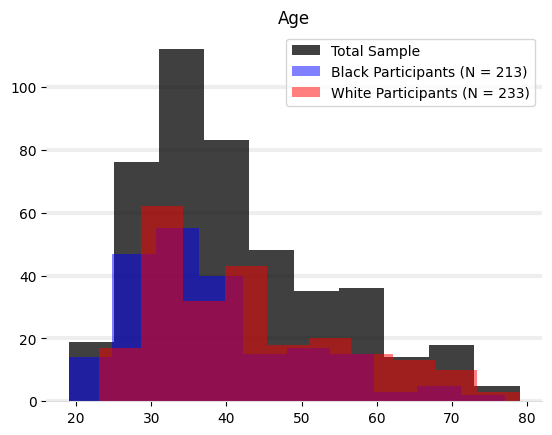

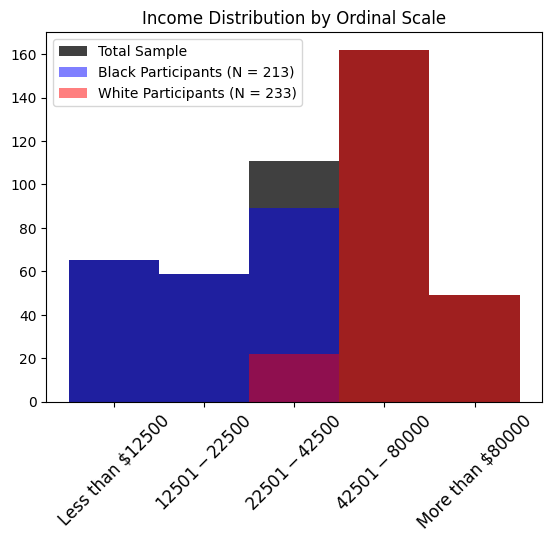

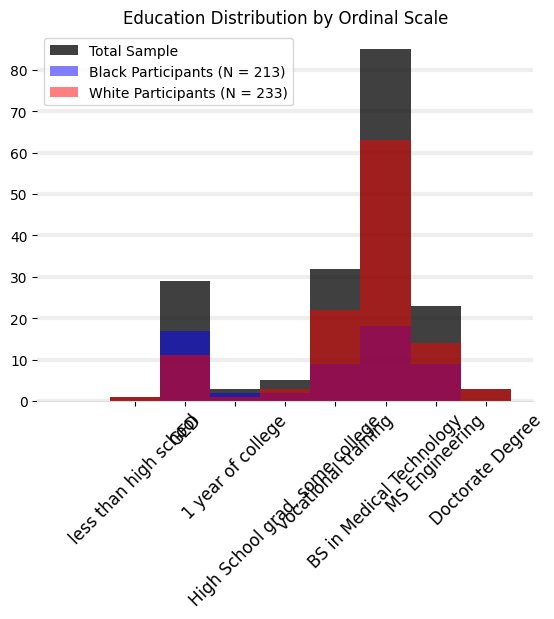

Mean News consumption bias for sample: 2.29 ( SD = 1.23 ; 95%CI 2.18 , 2.41 1=Left & 3=Center & 5=Right)
Mean News bias and CI for Black sample: 2.04  95%CI [ 1.89 , 2.19 ]
Mean News bias and CI for White sample: 2.52  95%CI [ 2.36 , 2.69 ]


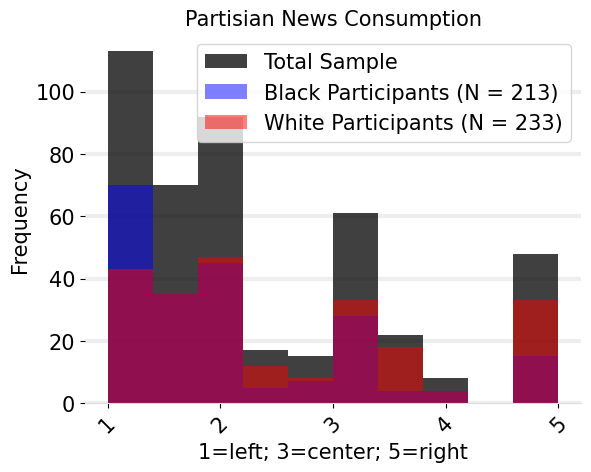

In [118]:
#@title Plot descriptive statistics
#Report Gender breakdown
propFemale = (sum(Gender_nGnANB==1)/len(Gender_nGnANB))*100
propFemale = round(propFemale,2)
print('The sample is',propFemale, '% Female and', (100-propFemale),'% Male')

#Report racial breakdown
propBlack = (sum(blackCode_nGnANB==1)/len(blackCode_nGnANB))*100
propBlack = round(propBlack,2)
print('The sample is',propBlack, '% Black and', (100-propBlack),'% White')

#Create race masks
bIndx_nGnANB = blackCode_nGnANB == 1
wIndx_nGnANB = blackCode_nGnANB == 0

#Compute Race-Gender proportions
FemaleRecoded = Gender_nGnANB*2
RaceGenderInteract = blackCode_nGnANB+FemaleRecoded
WhiteMaleCount = len(np.where(RaceGenderInteract == 0)[0])
WhiteFemaleCount = len(np.where(RaceGenderInteract == 2)[0])
BlackMaleCount = len(np.where(RaceGenderInteract == 1)[0])
BlackFemaleCount = len(np.where(RaceGenderInteract == 3)[0])
print('The number of White Males is: ' + str(WhiteMaleCount))
print('The number of White Females is: ' + str(WhiteFemaleCount))
print('The number of Black Males is: ' + str(BlackMaleCount))
print('The number of Black Females is: ' + str(BlackFemaleCount))

# Plot age histograms
Age_mean = np.mean(Age_nGnANB)
Age_sd = np.std(Age_nGnANB)
print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')
fig, ax = plt.subplots()
plt.hist(Age_nGnANB, alpha=0.75, color= 'k')
plt.hist(Age_nGnANB[bIndx_nGnANB], alpha=0.5, color= 'b')
plt.hist(Age_nGnANB[wIndx_nGnANB], alpha=0.5, color= 'r')
print(f'Mean age for Black sample: ', round(np.mean(Age_nGnANB[bIndx_nGnANB]),2))
print(f'Mean age for White sample: ', round(np.mean(Age_nGnANB[wIndx_nGnANB]),2))
plt.title('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
labels= ["Total Sample","Black Participants (N = 213)", "White Participants (N = 233)"]
plt.legend(labels)
plt.show()


# Plot Income histograms
plt.hist(Income_nGnANB['Income_nGnANB_Ordinal'], bins=np.arange(6)-0.5, alpha=0.75, color='k', label="Total Sample")
plt.hist(Income_nGnANB['Income_nGnANB_Ordinal'][bIndx_nGnANB], bins=np.arange(6)-0.5, alpha=0.5, color='b', label="Black Participants (N = 213)")
plt.hist(Income_nGnANB['Income_nGnANB_Ordinal'][wIndx_nGnANB], bins=np.arange(6)-0.5, alpha=0.5, color='r', label="White Participants (N = 233)")
plt.title('Income Distribution by Ordinal Scale')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)

plt.xticks(ticks=np.arange(5), labels=customSort.keys(), rotation=45, fontsize=12)

plt.legend()
plt.show()

#plot Education Hisotgram
fig, ax = plt.subplots()

plt.hist(Education_nGnANB['Education_nGnANB_Ordinal'].dropna(), bins=np.arange(10)-0.5, alpha=0.75, color='k', label="Total Sample")
plt.hist(Education_nGnANB.loc[Education_nGnANB.index.isin(bEducation.index), 'Education_nGnANB_Ordinal'].dropna(), bins=np.arange(10)-0.5, alpha=0.5, color='b', label="Black Participants (N = 213)")
plt.hist(Education_nGnANB.loc[Education_nGnANB.index.isin(wEducation.index), 'Education_nGnANB_Ordinal'].dropna(), bins=np.arange(10)-0.5, alpha=0.5, color='r', label="White Participants (N = 233)")

plt.title('Education Distribution by Ordinal Scale')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)

# Get unique ordinal values for education, excluding NaN values
unique_edu_ordinals = sorted(Education_nGnANB['Education_nGnANB_Ordinal'].dropna().unique())

# Create a dictionary mapping ordinal values to preferred labels
edu_labels = {v: k for k, v in customSort_edu.items()}

# Set xticks and labels based on unique ordinal values
plt.xticks(ticks=unique_edu_ordinals,
           labels=[edu_labels.get(ord, '') for ord in unique_edu_ordinals],  # Get label from edu_labels, or '' if not found
           rotation=45, fontsize=12)

plt.legend()
plt.show()

# Plot NewsBias histograms
Newsbias_mean = np.mean(NewsBias_nGnANB)
Newsbias_sd = np.std(NewsBias_nGnANB)
Newsbias_CI = mean_confidence_interval(NewsBias_nGnANB, 0.95)
print(f'Mean News consumption bias for sample:', round(Newsbias_mean,2), '( SD =', round(Newsbias_sd,2), '; 95%CI',  round(Newsbias_CI[1],2),',', round(Newsbias_CI[2],2), '1=Left & 3=Center & 5=Right)')

#Compute bias by group
bNewsBias_mean = np.mean(NewsBias_nGnANB[bIndx_nGnANB])
bNewsbias_CI = mean_confidence_interval(NewsBias_nGnANB[bIndx_nGnANB], 0.95)
wNewsBias_mean = np.mean(NewsBias_nGnANB[wIndx_nGnANB])
wNewsbias_CI = mean_confidence_interval(NewsBias_nGnANB[wIndx_nGnANB], 0.95)
print(f'Mean News bias and CI for Black sample:', round(bNewsBias_mean,2), ' 95%CI [',  round(bNewsbias_CI[1],2),',', round(bNewsbias_CI[2],2), ']')
print(f'Mean News bias and CI for White sample:', round(wNewsBias_mean,2), ' 95%CI [',  round(wNewsbias_CI[1],2),',', round(wNewsbias_CI[2],2), ']')

fig, ax = plt.subplots()
plt.hist(NewsBias_nGnANB.sort_values(axis=0), alpha=0.75, color='k')
plt.hist(NewsBias_nGnANB[bIndx_nGnANB].sort_values(axis=0), alpha=0.5, color='b')
plt.hist(NewsBias_nGnANB[wIndx_nGnANB].sort_values(axis=0), alpha=0.5, color='r')
plt.title('Partisian News Consumption', size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
plt.xlabel('1=left; 3=center; 5=right', size=15)
plt.ylabel('Frequency', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
labels= ["Total Sample","Black Participants (N = 213)", "White Participants (N = 233)"]
plt.legend(labels, prop={'size': 15})

plt.xticks(rotation = 45)
plt.show()

In [103]:
# @title Old Graphing Code
# fig, ax = plt.subplots()
# customSort = {'Less than $12500':0, '$12501-$22500':1, '$22501-$42500':2, '$42501-$80000':3 ,'More than $80000':4}
# IncPlot = Income_nGnANB.sort_values(key=lambda x: x.map(customSort))
# bIncPlot = Income_nGnANB[bIndx_nGnANB].sort_values(key=lambda x: x.map(customSort))
# wIncPlot = Income_nGnANB[wIndx_nGnANB].sort_values(key=lambda x: x.map(customSort))
# plt.hist(IncPlot, alpha=0.75, color='k')
# plt.hist(bIncPlot, alpha=0.5, color='b')
# plt.hist(wIncPlot, alpha=0.5, color='r')
# plt.title('Income')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('#DDDDDD')
# ax.set_axisbelow(True)
# ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
# ax.xaxis.grid(False)
# plt.xticks(ticks=range(len(customSort)), labels=customSort, rotation=45, fontsize=12)
# plt.xticks(rotation = 45)
# plt.legend(["Total Sample","Black Participants (N = 213)", "White Participants (N = 233)"])
# plt.show()

# #Obtain Income counts for White partiicpants
# len(np.where(bIncPlot == 'Less than $12500')[0])
# len(np.where(bIncPlot == '$12501-$22500')[0])
# len(np.where(bIncPlot == '$22501-$42500')[0])
# len(np.where(bIncPlot == '$42501-$80000')[0])
# len(np.where(bIncPlot == 'More than $80000')[0])

# #Obtain Income counts for White partiicpants
# len(np.where(wIncPlot == 'Less than $12500')[0])
# len(np.where(wIncPlot == '$12501-$22500')[0])
# len(np.where(wIncPlot == '$22501-$42500')[0])
# len(np.where(wIncPlot == '$42501-$80000')[0])
# len(np.where(wIncPlot == 'More than $80000')[0])

PRaM reliability for Total sample: 0.93
PRaM reliability for Black sample: 0.94
PRaM reliability for White sample: 0.92


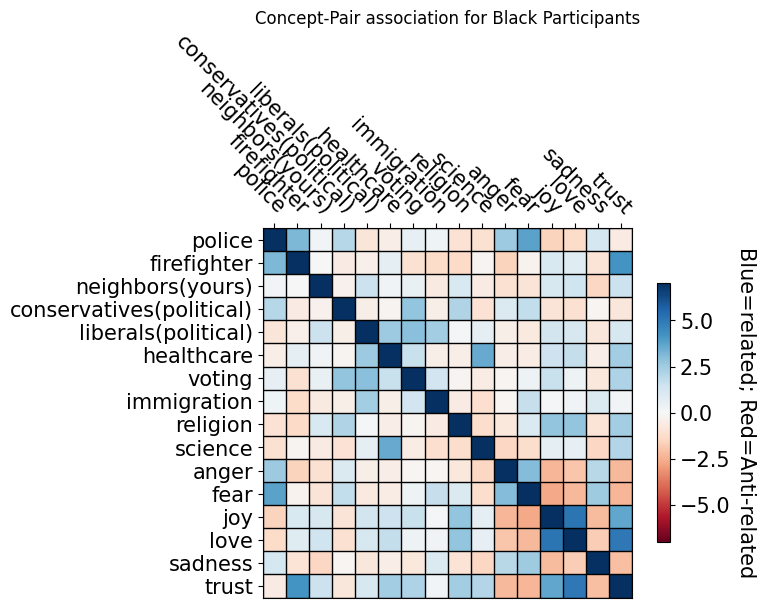

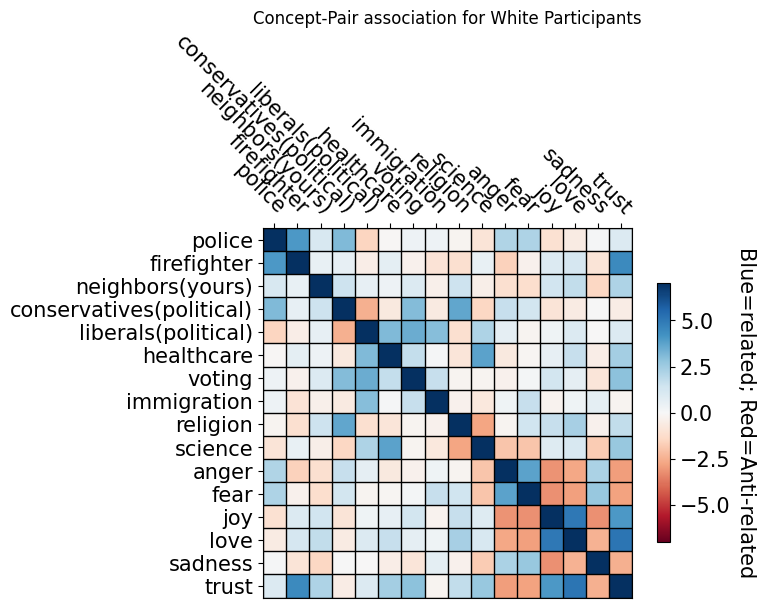

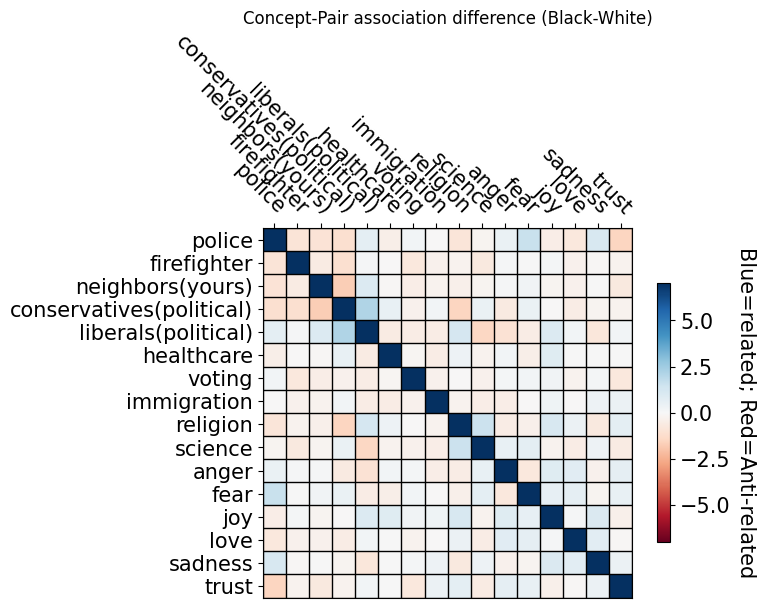

In [ ]:
# @title Descriptive analysis of PRaM
#Subset data for Black and White Participants
bPRaM_nGnANB = PRaM_nGnANB[bIndx_nGnANB,:]
wPRaM_nGnANB = PRaM_nGnANB[wIndx_nGnANB,:]


# Average pair distance
avgDist = np.mean(PRaM_nGnANB, axis=0)
avgBDist = np.mean(bPRaM_nGnANB, axis=0)
avgWDist = np.mean(wPRaM_nGnANB, axis=0)

#Participant-wise normalization
PRaMz = stats.zscore(PRaM_nGnANB, axis=0)
bPRaMz = stats.zscore(bPRaM_nGnANB, axis=0)
wPRaMz = stats.zscore(wPRaM_nGnANB, axis=0)

#Convert to dataframes for Reliabiltiy calc
PRaMz = pd.DataFrame(PRaMz)
bPRaMz = pd.DataFrame(bPRaMz)
wPRaMz = pd.DataFrame(wPRaMz)

# Splithalf Reliability
perm = 10000
rhoPRaM = splitHalf_Reliability(PRaMz, perm)
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Total sample:', round(rhoPRaM,2))
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBDist, words,1, "Concept-Pair association for Black Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWDist, words,1, "Concept-Pair association for White Participants", 'Blue=related; Red=Anti-related'); # Compute association matrix for White participants
diffPRaM_Weights = weightedHeatmap((avgBDist-avgWDist), words,1, "Concept-Pair association difference (Black-White)", 'Blue=related; Red=Anti-related'); # Compute association matrix for Black-White differences

In [ ]:
# @title Reset index and reshape for concatonation

#Income [Higher value means higher income bracket] [Note: This is coming later for plot formatting purposes]
i0Ind = Income_nGnANB.str.contains(pat = 'Less than $12500', case=False, regex=False)
i1Ind = Income_nGnANB.str.contains(pat = '$12501-$22500', case=False, regex=False)
i2Ind = Income_nGnANB.str.contains(pat = '$22501-$42500', case=False, regex=False)
i3Ind = Income_nGnANB.str.contains(pat = '$42501-$80000', case=False, regex=False)
i4Ind = Income_nGnANB.str.contains(pat = 'More than $80000', case=False, regex=False)
Income_nGnANB.loc[i0Ind] = 0
Income_nGnANB.loc[i1Ind] = 1
Income_nGnANB.loc[i2Ind] = 2
Income_nGnANB.loc[i3Ind] = 3
Income_nGnANB.loc[i4Ind] = 4
Income_nGnANB = Income_nGnANB


#Simplify variable  names
blackCoded = blackCode_nGnANB
femaleCoded = Gender_nGnANB
Income = Income_nGnANB
Age = Age_nGnANB
NewsBias = NewsBias_nGnANB

#Reset index for series (just in case)
#blackCoded = blackCoded.reset_index(drop=True)
#blackCoded = blackCoded.to_numpy() #convert series to array
femaleCoded = femaleCoded.reset_index(drop=True)
femaleCoded = femaleCoded.to_numpy() #convert series to array
Income = Income.reset_index(drop=True)
Income = Income.to_numpy()  #convert series to array
#Age = Age.reset_index(drop=True)
#Age = Age.to_numpy()  #convert series to array
NewsBias = NewsBias.reset_index(drop=True)
NewsBias = NewsBias.to_numpy()  #convert series to array

#Reshape for concatenation
blackCoded =  blackCoded.reshape(blackCoded.shape[0],1)
femaleCoded =  femaleCoded.reshape(femaleCoded.shape[0],1)
Income =  Income.reshape(Income.shape[0],1)
Age =  Age.reshape(Age.shape[0],1)
NewsBias = NewsBias.reshape(NewsBias.shape[0],1)

In [ ]:
# @title Convert similarity ratings to edge distances
PRaM_edge = 1-(PRaM_nGnANB-(-7))/(7-(-7)) #Normalize each similarity rating between 0 and 1 and reverse polarity such that 0 means maximally similar and 1 means maximally antipolar

In [ ]:
# @title Execute Permuted Multiple Regression model to measure Group differences
#Measure Word-Pair differences across group variables
#Permuted Multiple Regression model
#Y is 120 pair-distances (seperate models for each word pair)
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing (scramble Y) and FDR correction are also computed

#Group breakdown:
#----------------------------
#Race (Black identity is dummy coded)
#Gender (Female identity is dummy coded)
#Income (Coverted to an ordinal scale with higher values meaning greater income bracket)
#Age
#NewsBiasConsumption=Political

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Concatonate
X = np.concatenate((blackCoded, femaleCoded, Income, Age, NewsBias), axis=1)

#Y: Pair data
PRaM = PRaM_edge #Use 'PRaM_nGnANB' for similarity-rating based analysis

bObsPairsPRaM = []
pPairsPRaM = []
perm = 10
#Iterate through concept-pairs
for i in tqdm(range(len(PairLabel))):
    # Isolate pair data
    Y = PRaM[:,i]

    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff(X, Y, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)
    #if i == 0:
    #  plt.hist(betaPerm1)

pPairsPRaM = pd.DataFrame(pPairsPRaM) #Convert to dataframe
bObsPairsPRaM = pd.DataFrame(bObsPairsPRaM)#Convert to dataframe

#Implement FDR correction
FDR_sig = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pPairsPRaM[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sig.append(FDR[0])
FDR_sig = pd.DataFrame(FDR_sig)

#Export data to CSV files
if use10000iter == 0:
  PrAM_final = pd.DataFrame(PRaM_nGnANB)
  FDR_sig.to_csv('FDRsig.csv')
  pPairsPRaM.to_csv('pValPairs.csv')
  bObsPairsPRaM.to_csv('bObsPairsPRaM.csv')
  PrAM_final.to_csv('PRaM_finalModel.csv')
elif use10000iter == 1:
  FDR_sig = pd.read_csv (path + 'analysis/FDRsig_edge_10000.csv', header=0, index_col=0)
  pPairsPRaM = pd.read_csv (path + 'analysis/pValPairs_edge_10000.csv', header=0, index_col=0) #First column refers to constant parameter
  bObsPairsPRaM = pd.read_csv (path + 'analysis/bObsPairsPRaM_edge_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_edge_10000.csv', header=0, index_col=0)
  PrAM_final = pd.DataFrame(PRaM)

100%|██████████| 120/120 [00:00<00:00, 302.35it/s]


In [ ]:
# @title Structure and Subset data for vizualization

PrAM_finalSim = pd.DataFrame(PRaM_nGnANB)

#Isolate booleans of significant edges
sigEdges = FDR_sig.transpose()
sigEdges = sigEdges.reset_index(drop=True)
sigEdges_race = sigEdges[0]
sigEdges_gender = sigEdges[1]
sigEdges_income = sigEdges[2]
sigEdges_age = sigEdges[3]
sigEdges_newsBias = sigEdges[4]

#Subset
#Isolate Black and White samples and subset by sig edges
bfIdx = blackCoded == 1
wfIdx = blackCoded == 0
bfPRaM = PrAM_finalSim[bfIdx]
wfPRaM = PrAM_finalSim[wfIdx]
bfPRaM_sigEdges = bfPRaM.loc[:,sigEdges_race]
wfPRaM_sigEdges = wfPRaM.loc[:,sigEdges_race]
raceEdges = PairLabel[sigEdges_race]

#Seperate news bias consumption into left and right leaning
leftNewsIdx = NewsBias < 3
rightNewsIdx = NewsBias > 3
lfPRaM = PrAM_finalSim[leftNewsIdx]
rtPRaM = PrAM_finalSim[rightNewsIdx]
lfPRaM_sigEdges = lfPRaM.loc[:,sigEdges_newsBias]
rtPRaM_sigEdges = rtPRaM.loc[:,sigEdges_newsBias]
newsEdges = PairLabel[sigEdges_newsBias]

#Compute subset means and SEM
bfsePRaM_mean = bfPRaM_sigEdges.mean(axis=0)
wfsePRaM_mean = wfPRaM_sigEdges.mean(axis=0)
bfsePRaM_SEM = np.std(bfPRaM_sigEdges, axis=0)/np.sqrt(bfPRaM_sigEdges.shape[0])
wfsePRaM_SEM = np.std(wfPRaM_sigEdges, axis=0)/np.sqrt(wfPRaM_sigEdges.shape[0])

lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])

#Compute CI for each group
bFsePRaM_CI95 = []
for cname, cdata in bfPRaM_sigEdges.items():
  CIi = mean_confidence_interval(cdata, 0.95)
  bFsePRaM_CI95.append(CIi[3])

wFsePRaM_CI95 = []
for cname, cdata in wfPRaM_sigEdges.items():
  CIi = mean_confidence_interval(cdata, 0.95)
  wFsePRaM_CI95.append(CIi[3])

lfsePRaM_CI95 = []
for cname, cdata in lfPRaM_sigEdges.items():
  CIi = mean_confidence_interval(cdata, 0.95)
  lfsePRaM_CI95.append(CIi[3])

rtsePRaM_CI95 = []
for cname, cdata in rtPRaM_sigEdges.items():
  CIi = mean_confidence_interval(cdata, 0.95)
  rtsePRaM_CI95.append(CIi[3])

In [ ]:
# @title Compute correlation between Age and "voting-joy" edge

#Generate observed correlation
AgeDF = pd.DataFrame(Age_nGnANB)
Age_VoteJoyCorr = AgeDF.corrwith(PrAM_final[80], method='pearson')

# Generate the permutations
perm = 10000
pComb = item_randperm(len(Age),perm)

rPermDist = []
for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = PrAM_final[80].loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = AgeDF.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if Age_VoteJoyCorr[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > Age_VoteJoyCorr[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif Age_VoteJoyCorr[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < Age_VoteJoyCorr[0]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

VoteJoymean = PrAM_final[80].mean()

va_r_CI = r_CI(Age_VoteJoyCorr,len(Age),0.95) #CI for voting/age

print('The correlation between Age and', PairLabel[0][80],  'edge is :', round(Age_VoteJoyCorr[0],3), '(p=',pval,')')
print('The mean of Vote-joy is:',VoteJoymean)
print('The lower and upper CI is:', va_r_CI[0][0], ' and ', va_r_CI[1][0])

100%|██████████| 10000/10000 [02:59<00:00, 55.65it/s]


The correlation between Age and voting-joy edge is : -0.162 (p= [0.0002] )
The mean of Vote-joy is: 0.3971812940422806
The lower and upper CI is: -0.2511684379263069  and  -0.07030197245322939


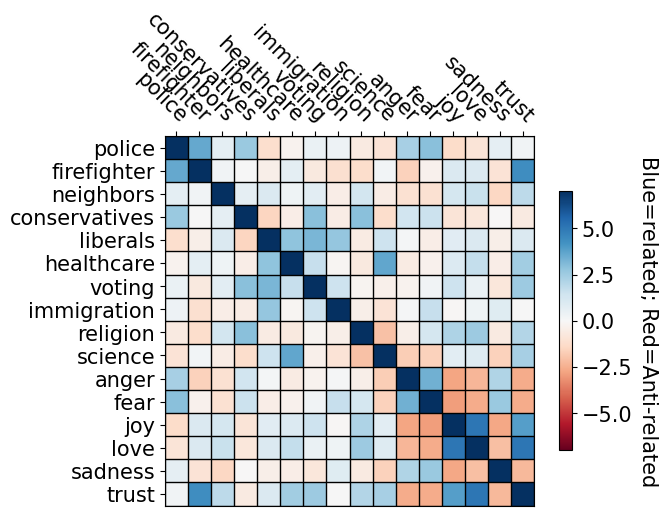

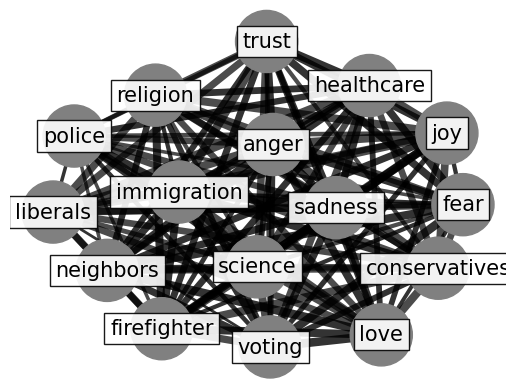

In [ ]:
# @title Figure 1 panel: (a) PRaM Schematic; (b) Heatmap of similarity ratings (c) Fully connected graph

#Create heat map of full sample [panel b]
words_trim = [re.sub("[\(].*?[\)]", "", w) for w in words]
PRaM_Weights = weightedHeatmap(avgDist, words_trim,1, '', 'Blue=related; Red=Anti-related')


#Create Fully-connected graph of associations [panel c]
PrAM_final = PrAM_final #This is in edge space
PrAM_meanEdge = PrAM_final.mean(axis=0)
#PrAM_meanEdge = (PrAM_mean - min(PrAM_mean)) / (max(PrAM_mean) - min(PrAM_mean)) #adjust range to be between 0 and 1
#PrAM_meanEdge = PrAM_meanEdge.reset_index(drop=True)
#PrAM_meanEdge = (PrAM_meanEdge + 0.01) *10 #add 0.1 to account for 0 and multiply edges by constant to aid with vizualization
conceptPairs = pd.Series(combinations_list)
conceptPairs_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs] #remove parenthetical text from nodes for easier reading

#Identify unique and overlapping edges between race and news
sigEdge_RNoverlap = np.logical_and(sigEdges_race, sigEdges_newsBias)
sigEdge_RaceUnq = np.logical_and(sigEdges_race, ~sigEdge_RNoverlap)
sigEdge_NewsUnq = np.logical_and(sigEdges_newsBias, ~sigEdge_RNoverlap)
sigEdges = np.logical_or(sigEdge_RaceUnq, sigEdge_NewsUnq)
sigEdges = np.logical_or(sigEdges, sigEdge_RNoverlap)

#Draw Graph for average participant
G = nx.Graph()
for e in range(len(conceptPairs_trim)):
  G.add_edge(conceptPairs_trim[e][0], conceptPairs_trim[e][1], weight = round(PrAM_meanEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options) #ADJUST LABELS HERE

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_RaceUnq = list(compress(EdgeList, sigEdge_RaceUnq))
EdgeList_NewsUnq = list(compress(EdgeList, sigEdge_NewsUnq))
EdgeList_RaceNewsOverlap = list(compress(EdgeList, sigEdge_RNoverlap))
EdgeList_nonSig = list(compress(EdgeList, ~sigEdges))

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_nonSig, width=edgewidth, alpha = 0.8) #draw all edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.7)#, edge_color="b") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_NewsUnq, width=edgewidth, alpha=0.7)#, edge_color="r") #draw news differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceNewsOverlap, width=edgewidth, alpha=0.7)#, edge_color="purple") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()

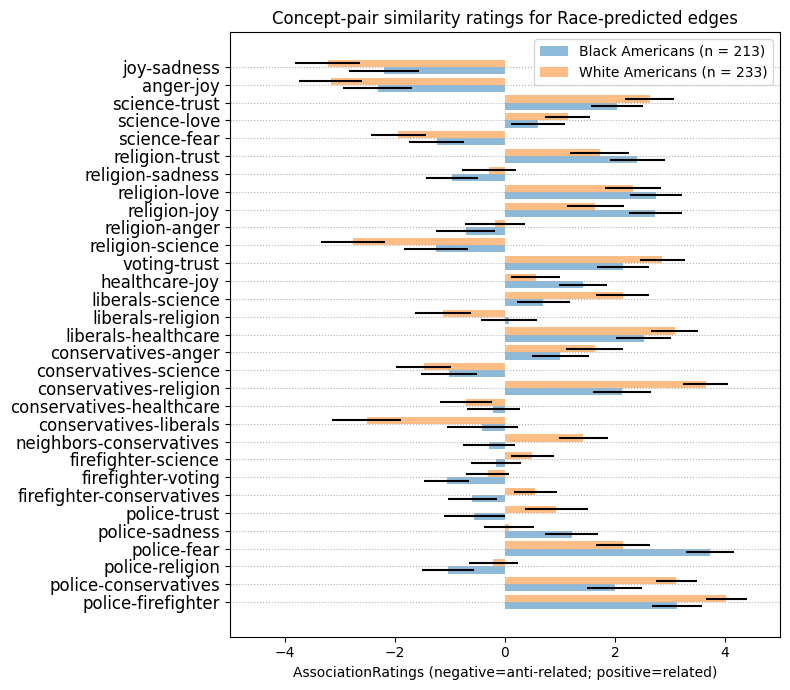

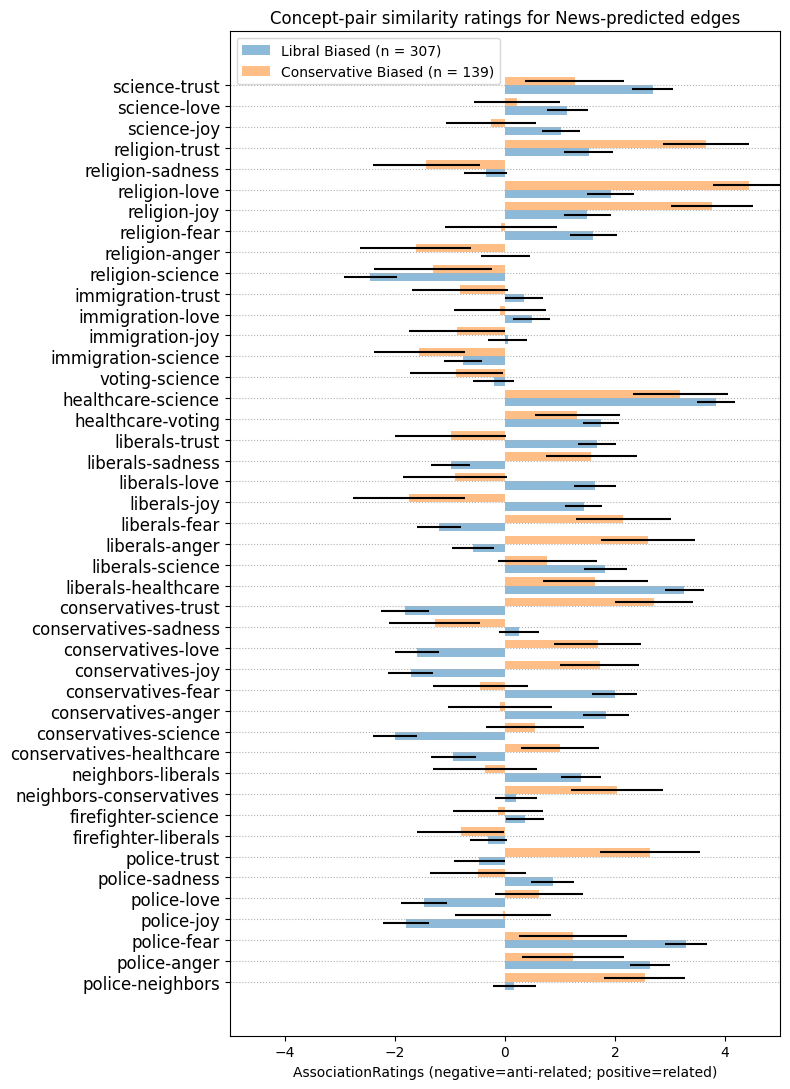

In [ ]:
# @title Vizualize Concept-pair Length Comparison for Significant Edges (This will also serve as the panel for Figure 2)

# Set bar width
bar_width = 0.4

#remove parentheticals
raceEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in raceEdges[0].values.tolist()]
newsEdges_trim = [re.sub("[\(].*?[\)]", "", w) for w in newsEdges[0].values.tolist()]

# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 7.0]
plt.rcParams["figure.autolayout"] = True
r1_race = np.arange(len(bfsePRaM_mean))
r2_race = [x + bar_width for x in r1_race]
fig, ax_race = plt.subplots()
blackN = len(bfPRaM_sigEdges)
whiteN = len(PrAM_finalSim)-blackN
bLabel = 'Black Americans (n = '+ str(blackN) + ')'
wLabel = 'White Americans (n = '+ str(whiteN) + ')'
ax_race.barh(r1_race, bfsePRaM_mean, xerr=bFsePRaM_CI95, height=bar_width, alpha=0.5, label=bLabel)
ax_race.barh(r2_race, wfsePRaM_mean, xerr=wFsePRaM_CI95, height=bar_width, alpha=0.5, label=wLabel)
plt.title('Concept-pair similarity ratings for Race-predicted edges')
ax_race.set_yticks([r + bar_width / 2 for r in range(len(bfsePRaM_mean))])
ax_race.set_yticklabels(raceEdges_trim, rotation=0, size=12)
#ax_race.grid(which = "minor", axis='y', linestyle = "dashed")
#ax_race.minorticks_on()
ax_race.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_race.legend()
plt.xlim([-5, 5])
ax_race.yaxis.grid(ls = 'dotted')
plt.show()


# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 11.0]
plt.rcParams["figure.autolayout"] = True
r1_news = np.arange(len(lfsePRaM_mean))
r2_news = [x + bar_width for x in r1_news]
fig, ax_news = plt.subplots()
leftN = len(lfPRaM_sigEdges)
rightN = len(NewsBias)-len(lfPRaM_sigEdges)
rLabel = 'Conservative Biased (n = '+ str(rightN) + ')'
lLabel = 'Libral Biased (n = '+ str(leftN) + ')'
ax_news.barh(r1_news, lfsePRaM_mean, xerr=lfsePRaM_CI95, height=bar_width, alpha=0.5, label=lLabel)
ax_news.barh(r2_news, rtsePRaM_mean, xerr=rtsePRaM_CI95, height=bar_width, alpha=0.5, label=rLabel)
plt.title('Concept-pair similarity ratings for News-predicted edges')
ax_news.set_yticks([r + bar_width / 2 for r in range(len(lfsePRaM_mean))])
ax_news.set_yticklabels(newsEdges_trim, rotation=0, size = 12)
ax_news.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_news.legend()
plt.xlim([-5, 5])
ax_news.yaxis.grid(ls = 'dotted')
plt.show()

In [ ]:
# @title Paper-relevant descriptive statistics
pd.set_option('mode.chained_assignment', None)
#Using data defined above
  # lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
  # rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
  # lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
  # rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])

#Create data frame of labels, policital means, and SEM
newsDiffRatings = newsEdges
newsDiffRatings['LeftRatings'] = lfsePRaM_mean
newsDiffRatings['RightRatings'] = rtsePRaM_mean
newsDiffRatings['LeftSEM'] = lfsePRaM_SEM
newsDiffRatings['RightSEM'] = rtsePRaM_SEM

display(newsDiffRatings)

,0,LeftRatings,RightRatings,LeftSEM,RightSEM
1,police-neighbors(yours),0.172638,2.544304,0.196302,0.368090
9,police-anger,2.635179,1.240506,0.184353,0.465167
10,police-fear,3.286645,1.240506,0.192397,0.489340
11,police-joy,-1.798046,-0.037975,0.209421,0.436459
12,police-love,-1.472313,0.620253,0.210458,0.401609
13,police-sadness,0.866450,-0.481013,0.196941,0.435510
14,police-trust,-0.462541,2.632911,0.236786,0.455055
17,firefighter-liberals(political),-0.299674,-0.797468,0.169770,0.394393
22,firefighter-science,0.364821,-0.126582,0.172150,0.410317
29,neighbors(yours)-conservatives(political),0.201954,2.037975,0.197532,0.414619


100%|██████████| 10000/10000 [05:07<00:00, 32.51it/s]


The r between Black identity and convervative news consumption is: -0.195 ,p= [0.0002] , [ -0.28 , -0.1 ]


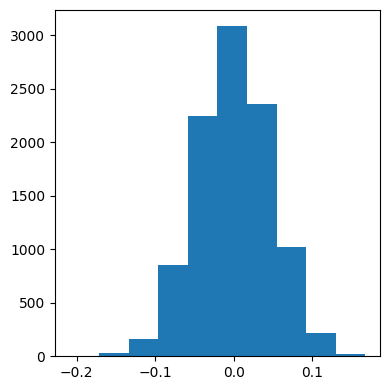

In [ ]:
# @title Establish correlational relationship between News Consumption and Racial Identity
#Establish relationship between News and Black Identity
blackCoded_Cor = pd.DataFrame(blackCoded)

NewsBias_Cor = pd.DataFrame(NewsBias)
obsCorr_BN = blackCoded_Cor.corrwith(NewsBias_Cor, method='pearson')


# Generate the permutations
perm = 10000
pComb = item_randperm(NewsBias_Cor.shape[0],perm)

rPermDist = []

for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = NewsBias_Cor.loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = blackCoded_Cor.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if obsCorr_BN[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_BN[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_BN[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_BN[0]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

raceNewsR_CI = r_CI(obsCorr_BN[0],444,0.95)

plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.hist(rPermDist)
print('The r between Black identity and convervative news consumption is:', round(obsCorr_BN[0],3), ',p=',pval,', [', round(raceNewsR_CI[0],2), ',', round(raceNewsR_CI[1],2), ']')


In [ ]:
# @title Measure non-Race identity variables with News consumption

#Compute Age correlation permutation
obsCorr_AN = AgeDF.corrwith(NewsBias_Cor, method='pearson')
print('Age/NewsConsumption r = ', obsCorr_AN[0])

rPermDist = []
for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = NewsBias_Cor.loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = AgeDF.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if obsCorr_AN[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_AN[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_AN[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_AN[0]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')
rci_ageNews = r_CI(obsCorr_AN[0],len(AgeDF),0.95)
print('Age/NewsConsumption r = ', round(obsCorr_AN[0],3), ',p=',pval,', [', round(rci_ageNews[0],2), ',', round(rci_ageNews[1],2), ']')


#Compute Income correlation permutation
IncomeDF = pd.DataFrame(Income_nGnANB)
obsCorr_IN = IncomeDF.corrwith(NewsBias_Cor, method='pearson')
print('Income/NewsConsumption r = ', obsCorr_IN[0])

rPermDist = []
for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = NewsBias_Cor.loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = IncomeDF.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if obsCorr_IN[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_IN[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_IN[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_IN[0]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')

rci_incomeNews = r_CI(obsCorr_IN[0],len(IncomeDF),0.95)
print('Income/NewsConsumption r = ', round(obsCorr_IN[0],3), ',p=',pval,', [', round(rci_incomeNews[0],2), ',', round(rci_incomeNews[1],2), ']')


#Compute Gender correlation permutation
GenderDF = pd.DataFrame(Gender_nGnANB)
obsCorr_GN = GenderDF.corrwith(NewsBias_Cor, method='pearson')

rPermDist = []
for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = NewsBias_Cor.loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = GenderDF.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if obsCorr_GN[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_GN[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_GN[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_GN[0]])
  pb = nBbeyond/perm
  pval.append(pb)
else:
  raise ValueError('observed beta is exactly equal to 0')

rci_genderNews = r_CI(obsCorr_GN[0],len(GenderDF),0.95)
print('Gender/NewsConsumption r = ', round(obsCorr_GN[0],3), ',p=',pval,', [', round(rci_genderNews[0],2), ',', round(rci_genderNews[1],2), ']')


Age/NewsConsumption r =  0.10027504247656734


100%|██████████| 10000/10000 [02:56<00:00, 56.81it/s]


Age/NewsConsumption r =  0.1 ,p= [0.0199] , [ 0.01 , 0.19 ]
Income/NewsConsumption r =  -0.038196171307966646


100%|██████████| 10000/10000 [03:16<00:00, 50.97it/s]


Income/NewsConsumption r =  -0.038 ,p= [0.2326] , [ -0.13 , 0.05 ]


100%|██████████| 10000/10000 [03:20<00:00, 49.97it/s]


Gender/NewsConsumption r =  0.043 ,p= [0.2135] , [ -0.05 , 0.14 ]


In [ ]:
# @title Mediation analysis measuring effect of Black Identity (X) on Pair-distances (Yi) through News Consumption Bias (m)
warnings.filterwarnings('ignore')

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Subset Mediation analysis by sig edges
PRaM_sigNewsEdges = PrAM_final.loc[:,sigEdges_newsBias]

#X: Black Identity
X_med = blackCoded.reshape(blackCoded.shape[0]) #adjust shape to fit

#m: News Consumption Bias
m_med = NewsBias

#Y: Pair data
Y_med = PRaM_sigNewsEdges.to_numpy()

#Loop through each pair and compute a permutation scrambling Y
ObsPairsPRaM_med = pd.DataFrame({'TotEff':[],'MedEff':[], 'DirEff':[], 'SumEff':[], 'SobelT':[]})
pPairsPRaM_med = pd.DataFrame({'Totpval':[],'Medpval':[], 'Dirpval':[], 'Sumpval':[], 'SobelTpval':[]})
perm = 10
#Iterate through concept-pairs
for i in tqdm(range(Y_med.shape[1])):
  # Isolate pair data
  yi = Y_med[:,i]
  #Dummy coded linear regression
  #Compared against permuted distribution
  medObs_PRaM, pval_PRaM = mediationPerm(X_med, m_med, yi, perm)

  #Update output
  ObsPairsPRaM_med = pd.concat([ObsPairsPRaM_med,medObs_PRaM],ignore_index=True)
  pPairsPRaM_med = pd.concat([pPairsPRaM_med, pval_PRaM],ignore_index=True)

#Implement FDR correction

FDR_sigMed = []
import statsmodels as sm
for columnName, columnData in pPairsPRaM_med.items():
  FDR = sm.stats.multitest.fdrcorrection(columnData, alpha=0.05, method='indep', is_sorted=False)
  FDR_sigMed.append(FDR[0])
FDR_sigMed = pd.DataFrame(FDR_sigMed)

#Export data to CSV files
if use10000iter == 0:
  PrAM_save = pd.DataFrame(PRaM_nGnANB)
  FDR_sigMed.to_csv('FDRsigMed.csv')
  pPairsPRaM_med.to_csv('pPairsPRaM_med.csv')
  ObsPairsPRaM_med.to_csv('ObsPairsPRaM_med.csv')
  PrAM_save.to_csv('PRaM_finalModel_med.csv')
elif use10000iter == 1:
  FDR_sigMed = pd.read_csv (path + 'analysis/FDRsigMed_edge_10000.csv', header=0, index_col=0)
  pPairsPRaM_med = pd.read_csv (path + 'analysis/pPairsPRaMmed_edge_10000.csv', header=0, index_col=0)
  ObsPairsPRaM_med = pd.read_csv (path + 'analysis/ObsPairsPRaMmed_edge_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_med_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.DataFrame(PRaM_nGnANB)

100%|██████████| 44/44 [00:01<00:00, 25.83it/s]


Graph Centrality
police           0.43
firefighter      0.29
conservatives    0.57
religion         0.64
fear             0.14
sadness          0.21
trust            0.29
voting           0.14
science          0.50
neighbors        0.07
liberals         0.29
healthcare       0.21
anger            0.21
joy              0.29
love             0.14
dtype: float64


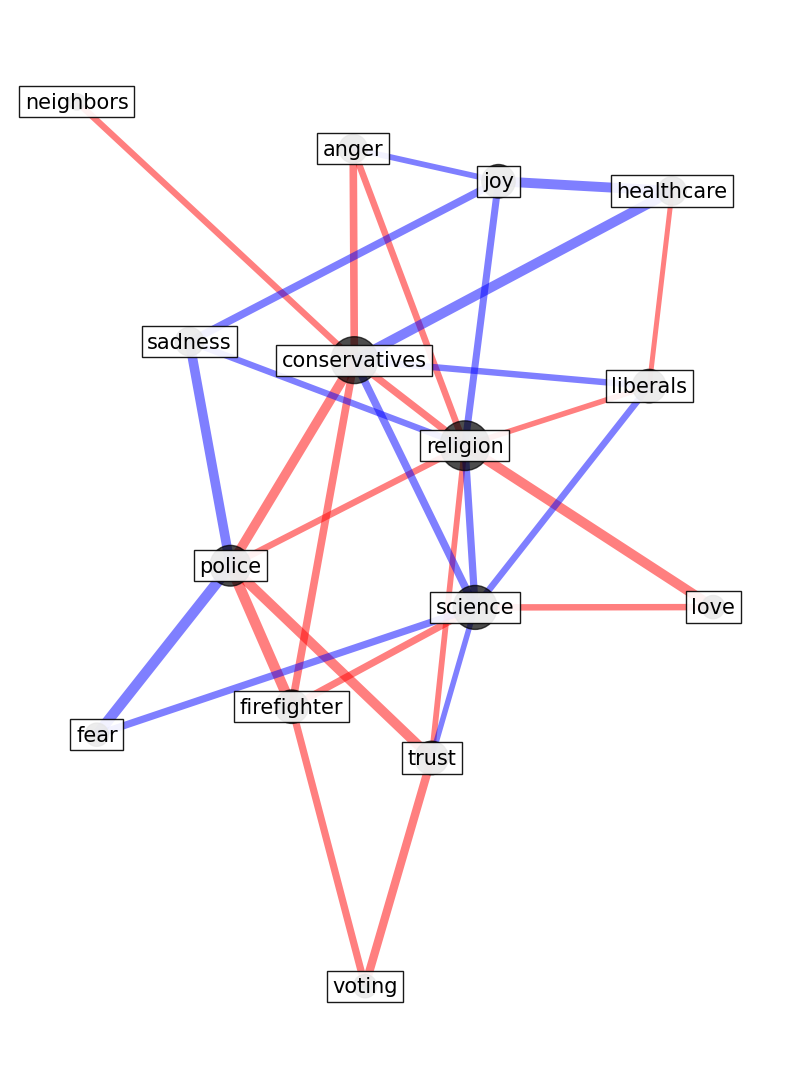

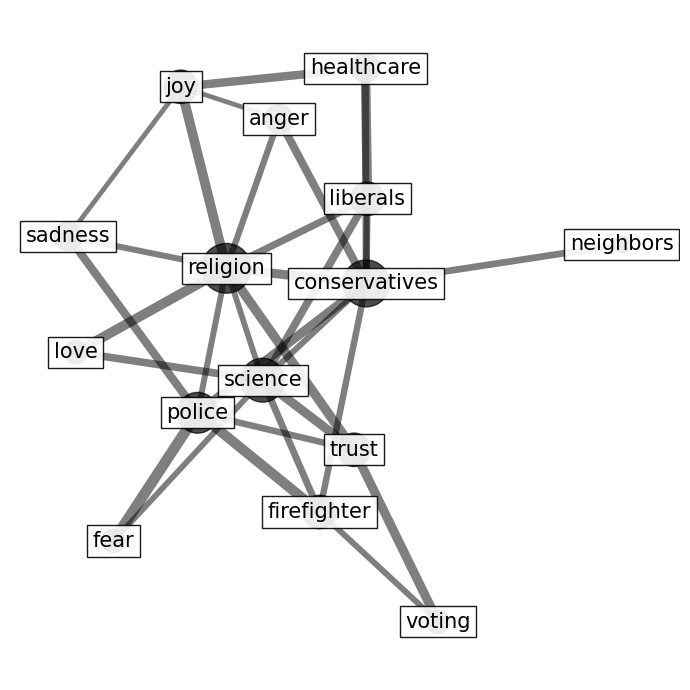

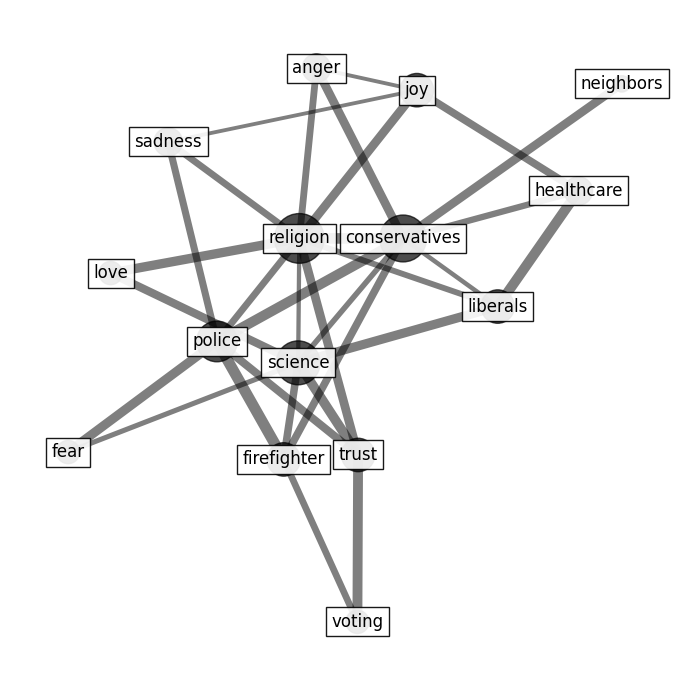

In [ ]:
# @title Figure 2: Group diff. Panel (a) Graph with racediffering edges. (b)bar graph (c) black graph (d) white graph

PrAM_final_reverse = (1 - PrAM_final)*2 #Reverse direction because networkx weights are such that high values meen shroter edges
seedn = 9
#Panel (a): Draw Graph for average participant
PrAM_finalRaceEdges = PrAM_final_reverse.loc[:,sigEdges_race] #This is in edge space
PrAM_meanRaceEdge = PrAM_finalRaceEdges.mean(axis=0)
PrAM_meanRaceEdge = PrAM_meanRaceEdge.reset_index(drop=True)

conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
conceptPairs_race = conceptPairs_race.reset_index(drop=True)
conceptPairsRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_race] #remove parenthetical text from nodes for easier reading


#Generate index of betas to reflect direction
raceBetas = bObsPairsPRaM['1']
raceBetas = raceBetas.loc[sigEdges_race]
raceBetas = raceBetas.reset_index(drop=True)
raceEdges_posBetas = raceBetas > 0 #Going from 0(white) to 1(black) results in an increase in edge distance
raceEdges_negBetas = raceBetas < 0 #Going from 0(white) to 1(black) results in an decrease in edge distance


G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_posBeta = list(compress(EdgeList, raceEdges_posBetas))
EdgeList_negBeta = list(compress(EdgeList, raceEdges_negBetas))


# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_posBeta, width=edgewidth, alpha = 0.5, edge_color="r") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_negBeta, width=edgewidth, alpha= 0.5, edge_color="b") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (b): Use table of mean similarity differences by race-differing edges


#Panel (c): Same as a except use Black participant edges instead of group
PrAM_RaceEdges_blackp = PrAM_final_reverse.loc[bfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_blackp = PrAM_RaceEdges_blackp.mean(axis=0)
PrAM_meanRaceEdges_blackp = PrAM_meanRaceEdges_blackp.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_blackp[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()

#Panel (d): Graph of white partiicpants
PrAM_RaceEdges_whitep = PrAM_final_reverse.loc[wfIdx,sigEdges_race] #This is in edge space
PrAM_meanRaceEdges_whitep = PrAM_RaceEdges_whitep.mean(axis=0)
PrAM_meanRaceEdges_whitep = PrAM_meanRaceEdges_whitep.reset_index(drop=True)

G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdges_whitep[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=12, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="black") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



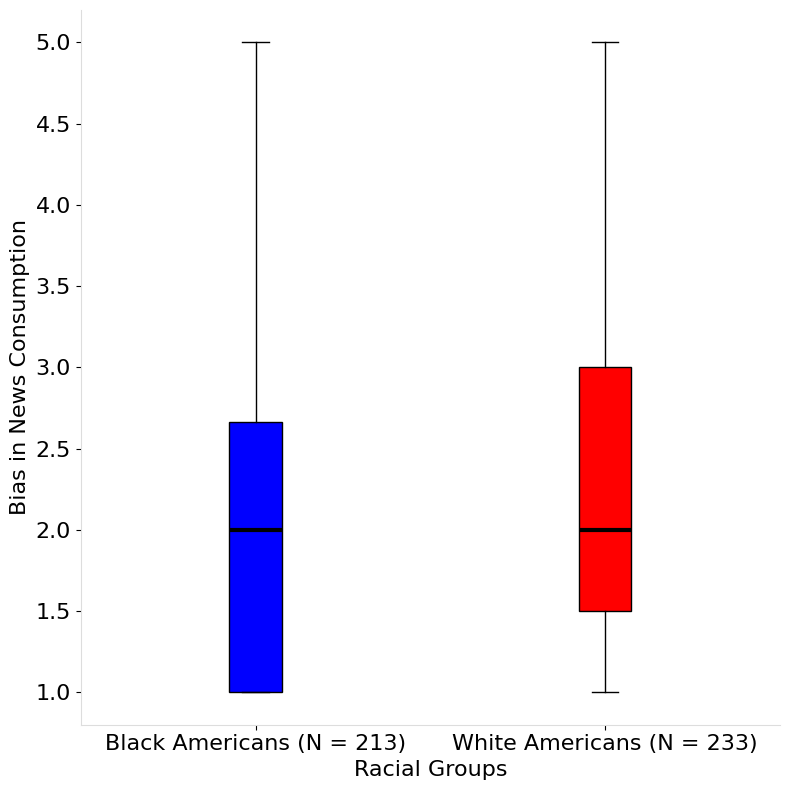

mean black news bias  2.04
mean white news bias  2.52
TtestResult(statistic=-4.215597620979234, pvalue=3.0208341802840313e-05, df=443.2382708909786)
Cohens d =  -0.3972883711628242
95%CI (-6.180928137062144, -2.2502671048963245)
Graph Centrality
police           0.23
fear             0.08
sadness          0.15
trust            0.23
firefighter      0.08
science          0.46
neighbors        0.08
conservatives    0.31
healthcare       0.15
anger            0.15
liberals         0.15
religion         0.46
joy              0.08
love             0.15
dtype: float64


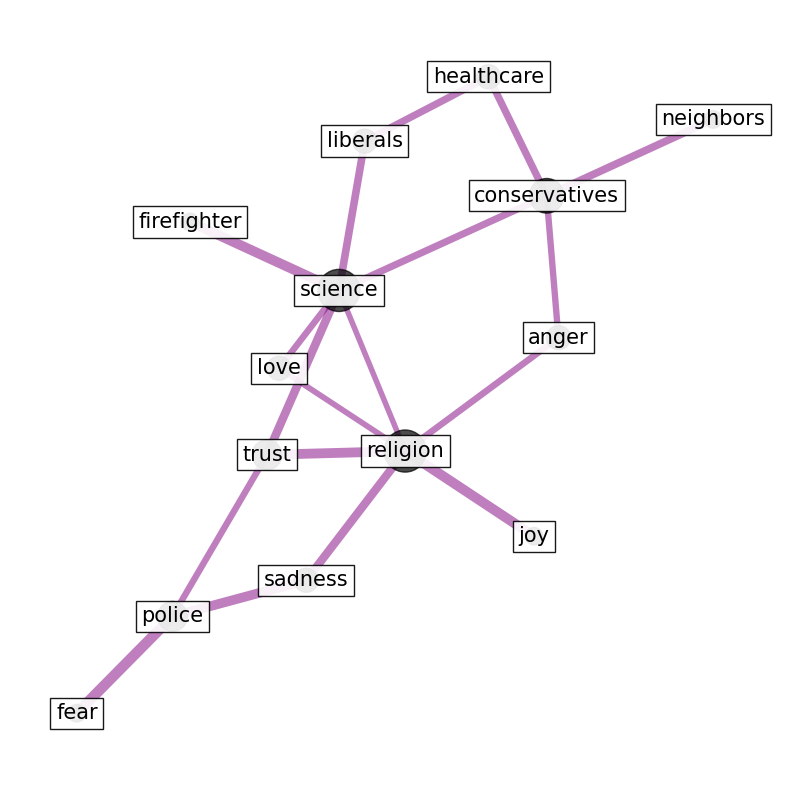

Graph Centrality
police           0.43
firefighter      0.29
conservatives    0.50
religion         0.50
fear             0.14
sadness          0.21
trust            0.29
voting           0.14
science          0.50
neighbors        0.07
liberals         0.29
healthcare       0.14
anger            0.14
joy              0.29
love             0.07
dtype: float64


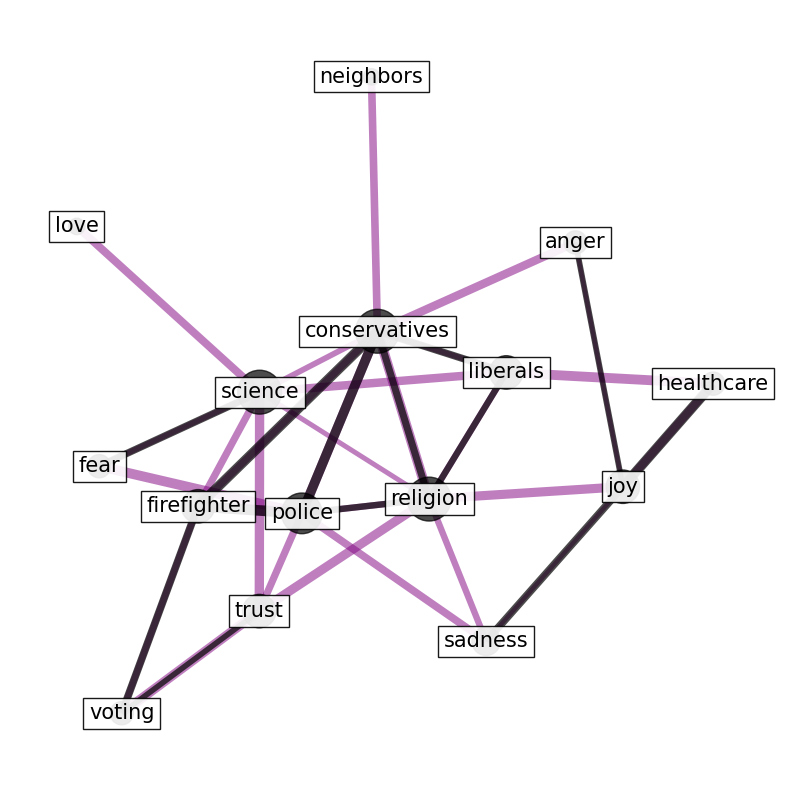

In [ ]:
# @title Figure 4: News bias diff Panel (a) Histogram of news bias both and individual racial groups. (b)bar graph showing mean and sd diff. (c) subgraph "Information" (indirect effects; ab[i.e., just mediated relationships]). (d) subgraph "Experience" (direct; c')


# Panel(a): histogram of political bias ratings

#Panel (b): Box plot of political bias by group
bNewsBias = NewsBias_nGnANB[bIndx_nGnANB]
wNewsBias = NewsBias_nGnANB[wIndx_nGnANB]

dat = [bNewsBias, wNewsBias]

#Panel (b): Bar plot of political bias by group
bNewsBias = NewsBias_nGnANB[bIndx_nGnANB]
wNewsBias = NewsBias_nGnANB[wIndx_nGnANB]

box = plt.boxplot(dat, labels=['Black Americans (N = 213)', 'White Americans (N = 233)'], patch_artist=True)
#plt.title('Partisian News Consumption by group', fontsize=18)
plt.ylabel('Bias in News Consumption', fontsize=16)
plt.xlabel('Racial Groups', fontsize=16)
plt.setp(box['medians'], color='black', linewidth=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#DDDDDD')
plt.gca().spines['bottom'].set_color('#DDDDDD')


barColors = ['b', 'r']
for p, c in zip(box['boxes'], barColors):
    p.set_facecolor(c)
plt.show()




#Test mean difference using a permuted test
#observed_diff, p_value = perm_meanDiff(bNewsBias,wNewsBias)

bNewsBias_mean = bNewsBias.mean()
wNewsBias_mean = wNewsBias.mean()
bNewsBias_std = bNewsBias.std()
wNewsBias_std = wNewsBias.std()

#Discontinuted barplot
# barDat = {'Black Americans':bNewsBias_mean, 'White Americans':wNewsBias_mean}
# groups = list(barDat.keys())
# meanBias = list(barDat.values())
# barSD = [bNewsbias_CI[3], wNewsbias_CI[3]]

# fig, ax = plt.subplots(figsize = (4, 4))
# # xtick_loc = [1, 1.5]
# # ax.set_xticks(xtick_loc)
# bars = plt.bar(groups, meanBias, yerr=barSD, width = 0.4, capsize=10)
# bars[0].set_color('b')
# bars[1].set_color('r')
# plt.ylim(1,5)
# plt.ylabel("Bias in News Consumption")
# plt.xticks
# #plt.errorbar(fmt='o', markersize=8, capsize=10)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('#DDDDDD')

# ax.set_axisbelow(True)
# ax.yaxis.grid(True, color='#EEEEEE')
# ax.xaxis.grid(False)
# plt.show()

print('mean black news bias ', round(bNewsBias_mean,2))
print('mean white news bias ', round(wNewsBias_mean,2))






#Compute t-test of news bias differences
newsRace_ttestResults = stats.ttest_ind(bNewsBias, wNewsBias, equal_var=False)
print(newsRace_ttestResults)

bwNews_d = cohensd(bNewsBias, wNewsBias)
print('Cohens d = ',bwNews_d)

newsDifft_CI = cit_difference(newsRace_ttestResults[0],newsRace_ttestResults.df,0.95)
print('95%CI',newsDifft_CI)


#Panel (c): Subgraph of mediated effects
PrAM_meanRaceEdge = PrAM_meanRaceEdge #Reversed (i.e. 1-OG edges) to be formatted for network x

#Get Booleans of Med and Direct effects
FDR_sigMedT = FDR_sigMed.transpose()
sigMediation = FDR_sigMedT[1]
sigDirect = FDR_sigMedT[2]
sigDirMed = pd.Series(list(compress(sigDirect, sigMediation)))
sigDirectUnq = pd.Series(list(compress(sigDirect, ~sigMediation)))
sigMediationUnq = pd.Series(list(compress(~sigDirMed, sigMediation)))

#Get full-set indicies of dir, med, and dir/med effects
newsSigIndex = [i for i, x in enumerate(sigEdges_newsBias) if x]
newsSigIndex_dir = list(compress(newsSigIndex, sigDirect))
newsSigIndex_med = list(compress(newsSigIndex, sigMediation))
newsSigIndex_dirMed = list(compress(newsSigIndex, sigDirMed))
newsSigIndex_dirUnq = list(compress(newsSigIndex, sigDirectUnq))
newsSigIndex_medUnq = list(compress(newsSigIndex, sigMediationUnq))

conceptPairs_newsDir = conceptPairs[newsSigIndex_dir]
conceptPairs_newsMed = conceptPairs[newsSigIndex_med]
# conceptPairs_newsDirMedUnq = conceptPairs[newsSigIndex_dirMed]
# conceptPairs_newsDirUnq = conceptPairs[newsSigIndex_dirUnq]
conceptPairs_newsMedUnq = conceptPairs[newsSigIndex_medUnq]

conceptPairs_newsDir = [(u,v) for (u,v) in conceptPairs_newsDir]
conceptPairs_newsMed = [(u,v) for (u,v) in conceptPairs_newsMed]
# conceptPairs_newsDirMedUnq = [(u,v) for (u,v) in conceptPairs_newsDirMedUnq]
# conceptPairs_newsDirUnq = [(u,v) for (u,v) in conceptPairs_newsDirUnq]
conceptPairs_newsMedUnq = [(u,v) for (u,v) in conceptPairs_newsMedUnq]

raceSigIndex = [i for i, x in enumerate(sigEdges_race) if x]
raceSigUnqEdges = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_unqRace = conceptPairs[raceSigUnqEdges]
conceptPairs_unqRace = [(u,v) for (u,v) in conceptPairs_unqRace]


#Set of racediffering concepts-pairs that are mediated by news
newsMedInRaceDiff = [i for i in newsSigIndex if i in raceSigIndex]
conceptPairs_newsMedInRace = conceptPairs[newsMedInRaceDiff]
conceptPairs_newsMedInRace = [(u,v) for (u,v) in conceptPairs_newsMedInRace]
conceptPairs_newsMedInRace_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_newsMedInRace] #remove parenthetical text from nodes for easier reading && #Use this edge list for panel c and for a purple set of edges in panel d


#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairs_newsMedInRace_trim)):
  G.add_edge(conceptPairs_newsMedInRace_trim[e][0], conceptPairs_newsMedInRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


#Panel (d): Subgraph of direct effects !!!!!!!!!!!!!!!!

#Set of racediffering concepts-pairs excluding those mediated by news
RaceDiffminusNewsMed = [i for i in raceSigIndex if i in newsSigIndex_medUnq]
RaceDiffminusNewsMed = [i for i in raceSigIndex if i not in RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = conceptPairs[RaceDiffminusNewsMed]
conceptPairs_RaceDiffminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffminusNewsMed] #Use this edge list for panel d [CORRECT]
conceptPairs_RaceDiffminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffminusNewsMed]

RaceDiffUnqminusNewsMed = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_RaceDiffUnqminusNewsMed = conceptPairs[RaceDiffUnqminusNewsMed]
conceptPairs_RaceDiffUnqminusNewsMed = [(u,v) for (u,v) in conceptPairs_RaceDiffUnqminusNewsMed] #Use this edge list for panel d [Correct]
conceptPairs_RaceDiffUnqminusNewsMed_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_RaceDiffUnqminusNewsMed]

#List of race-differing edges completely mediated by news consumption
conceptPairs_Race = conceptPairs[raceSigIndex]
conceptPairs_Race = [(u,v) for (u,v) in conceptPairs_Race]
conceptPairs_Race

li1 = conceptPairs_Race
li2 = conceptPairs_RaceDiffminusNewsMed

s = set(li2)
conceptPairs_Race_completeMediated = [x for x in li1 if x not in s]
conceptPairs_Race_completeMediated_trim = [[re.sub("[\(].*?[\)]", "", u),re.sub("[\(].*?[\)]", "", v)] for [u,v] in conceptPairs_Race_completeMediated]
conceptPairs_Race_completeMediated_trim


#Start drawing graph
G = nx.Graph()
for e in range(len(conceptPairsRace_trim)):
  G.add_edge(conceptPairsRace_trim[e][0], conceptPairsRace_trim[e][1], weight = round(PrAM_meanRaceEdge[e],3))

#Remove edges that are completely mediated by news consumption
for r in range(len(conceptPairs_Race_completeMediated_trim)):
  G.remove_edge(conceptPairs_Race_completeMediated_trim[r][0], conceptPairs_Race_completeMediated_trim[r][1])




pos = nx.spring_layout(G, iterations=10000, seed=seedn)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
print('Graph Centrality')
print(PRaM_graphCentrality)
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'black', alpha= 0.7)
label_options = {"ec": "k", "fc": "white", "alpha": 0.9}
nx.draw_networkx_labels(G, pos, font_size=15, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_Med = [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffminusNewsMed_trim]
EdgeList_UnqDir= [(u,v) for (u,v) in EdgeList if [u,v] in conceptPairs_RaceDiffUnqminusNewsMed_trim  or [v,u] in conceptPairs_RaceDiffUnqminusNewsMed_trim]

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 5 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_Med, width=edgewidth, alpha = 0.5, edge_color="purple") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_UnqDir, width=edgewidth, alpha = 0.7, edge_color="black") #draw race differing edges


#Set figure parameters
ax = plt.gca()
plt.axis("off")
#plt.title('Fully-connected graph of concept nodes and association edges')
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.show()


100%|██████████| 120/120 [00:00<00:00, 2120.99it/s]


Parameters [ 3.6326868e+01 -4.0004099e-03  2.7291127e+00]
CI: [[6.838002631905347, 65.81573335350785], [-0.029156415375022095, 0.021155595576377424], [2.4499416804739593, 3.008283720574718]]
RMSE: 0.18911345194876517
R-squared: 0.27125190048102676


100%|██████████| 120/120 [00:00<00:00, 47290.85it/s]


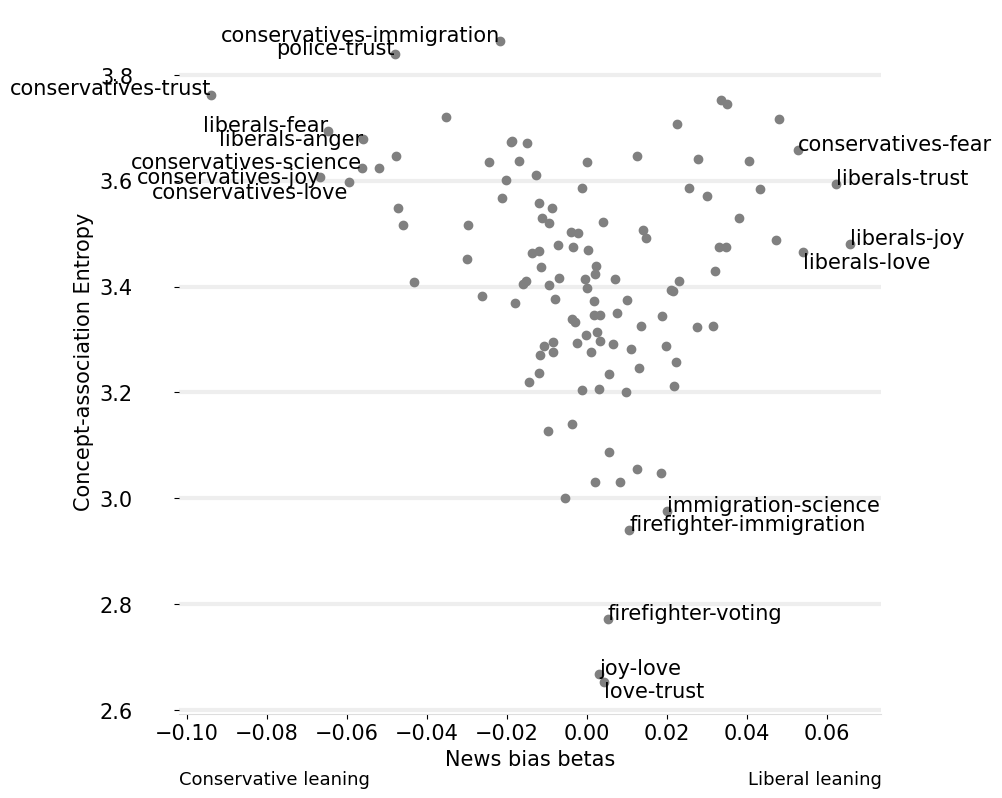

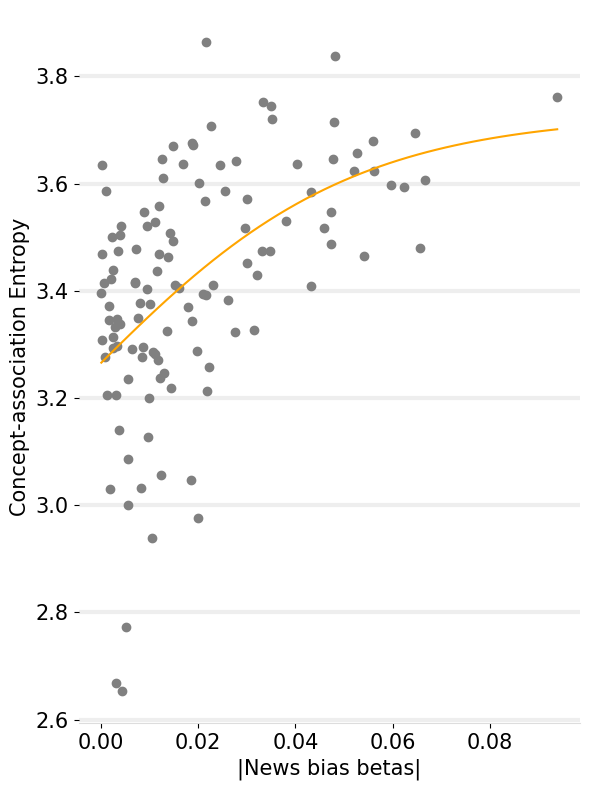

In [ ]:
# @title Figure 4: Edge entropy and news betas

#News predicting individal concept-pair edges
newsBetas = bObsPairsPRaM['5']

newsBetasAbs = np.absolute(newsBetas)
#Similarity data
PrAM_finalSim = PrAM_finalSim #cocnept-pairs in similarity space

#Shannon's entropy
base = 2  # work in units of bits

pairEntropy = []
for p in tqdm(range(len(PairLabel))):
  pairCounts = Counter(PrAM_finalSim[p])
  prop = []
  for c in pairCounts:
    propc = pairCounts[c]/PrAM_finalSim.shape[0]
    prop.append(propc)
  pk = prop
  H = entropy(pk, base=base)
  pairEntropy.append(H)

#Generate the line of best fit
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

newsBetasAbs = np.absolute(newsBetas)

xData = numpy.array(newsBetasAbs)
yData = numpy.array(pairEntropy)

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters)

absError = modelPredictions - yData

#Compute parameterwise CI
from scipy.stats import t
n = len(yData) #data points
p = len(fittedParameters) #number of parameters
alpha = 0.05

dof = max(0,n-p) #degrees of freedom
tval = t.ppf(1.0-alpha/2.,dof)
SE=[]
pint=[]
for i, p, var in zip(range(n), fittedParameters, np.diag(pcov)):
  sigma = var**0.5
  SE.append(sigma)
  pint.append([p-sigma*tval, p+sigma*tval])
print('CI:',pint)

#Report RMSE and Rsquard
SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


#Generate Entropy Plots
#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairEntropy)
Hmean = np.mean(pairEntropy)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairEntropy > ThrHu) | (pairEntropy < ThrHl)

combinedMask = ThrMaskb | ThrMaskH

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')



#Plot Scatter plots
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetas, pairEntropy, c ='grey')
plt.xlabel("News bias betas", size=15)
plt.ylabel("Concept-association Entropy", size=15)

##add point labels
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]
for i, txt in enumerate(pairLabelsScatter_trim):
  if (newsBetas[i] <= 0 and txt=='conservatives-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] <= 0 and txt=='liberals-anger'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='center', ha='right', size=15)
  elif (newsBetas[i] >= 0 and txt=='liberals-love'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif (newsBetas[i] >= 0 and txt=='love-trust'):
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), va='top', size=15)
  elif newsBetas[i] >= 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), size=15)
  elif newsBetas[i] < 0:
    ax.annotate(txt, (newsBetas[i], pairEntropy[i]), ha='right', size=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', pad=30)
ax.text(0, -0.1, 'Conservative leaning', transform=ax.transAxes, ha='left', size=13)
ax.text(1, -0.1, 'Liberal leaning', transform=ax.transAxes, ha='right', size=13)
plt.show()


#Plot absolute value plot
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairEntropy, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Concept-association Entropy", size=15)
# for i, txt in enumerate(pairLabelsScatter):
#   ax.annotate(txt, (newsBetasAbs[i], pairEntropy[i]))

#plt.annotate("R2 = {:.3f}".format(Rsquared), (0.06, 3.85), size=15)

# now the model as a line plot
xModel = numpy.linspace(min(xData), max(xData))
yModel = func(xModel, *fittedParameters)
ax.plot(xModel, yModel, color='orange')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

100%|██████████| 120/120 [00:00<00:00, 65689.96it/s]


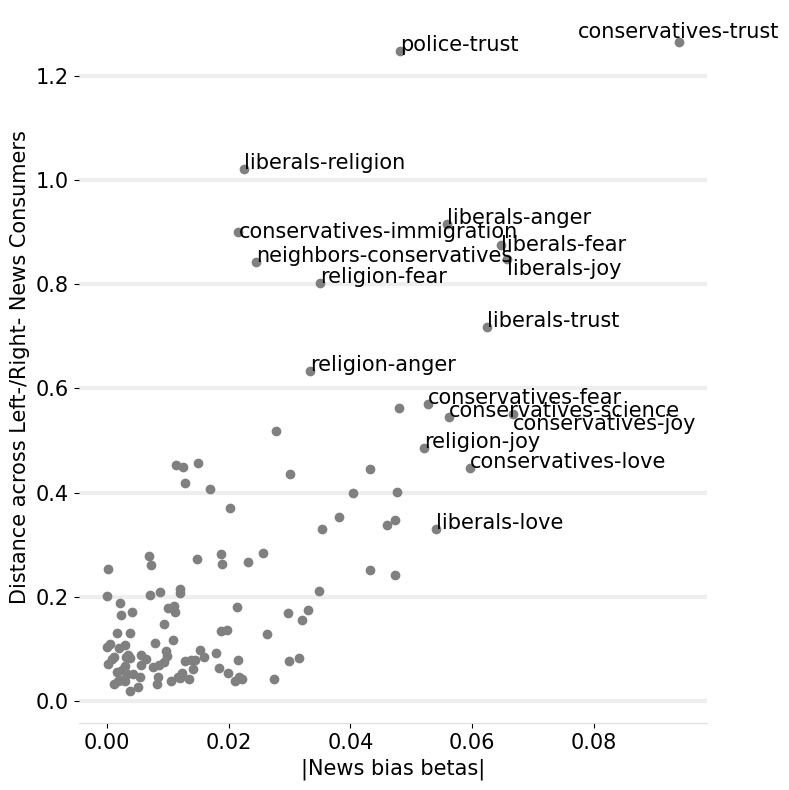

In [ ]:
# @title Representational distance by news bias effect (SI)
pairR = []

for p in tqdm(range(len(PairLabel))):
  lf = Counter(lfPRaM[p])
  rt = Counter(rtPRaM[p])

  tabulateRating = pd.DataFrame({'-7':[],'-6':[], '-5':[], '-4':[], '-3':[], '-2':[], '-1':[], '0':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[]})
  tabulateRating.loc[len(tabulateRating.index)] = [lf[-7], lf[-6], lf[-5], lf[-4], lf[-3], lf[-2], lf[-1], lf[0], lf[1], lf[2], lf[3], lf[4], lf[5], lf[6], lf[7]]
  tabulateRating.loc[len(tabulateRating.index)] = [rt[-7], rt[-6], rt[-5], rt[-4], rt[-3], rt[-2], rt[-1], rt[0], rt[1], rt[2], rt[3], rt[4], rt[5], rt[6], rt[7]]
  input = tabulateRating.transpose()
  r = np.corrcoef(input[0],input[1])
  pairR.append(1-r[0][1])

#Plot absolute value plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(newsBetasAbs,pairR, c ='grey')
plt.xlabel("|News bias betas|", size=15)
plt.ylabel("Distance across Left-/Right- News Consumers", size=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE', linewidth=3)
ax.xaxis.grid(False)
ax.tick_params(axis='both', which='major', labelsize=15)



#Threshold for labeling
bsd = np.std(newsBetas)
bmean = np.mean(newsBetas)
Thrbu = bmean + (1.8*bsd)
Thrbl = bmean - (2*bsd)
ThrMaskb = (newsBetas > Thrbu) | (newsBetas < Thrbl)

Hsd = np.std(pairR)
Hmean = np.mean(pairR)
ThrHu = Hmean + (1.9*Hsd)
ThrHl = Hmean - (1.9*Hsd)
ThrMaskH = (pairR > ThrHu) | (pairR < ThrHl)

combinedMask = ThrMaskb | ThrMaskH
combinedMask = (np.array(pairR) > 0.6) | (np.array(newsBetasAbs) > 0.05)

pairLabelsScatter = []
for p in tqdm(range(len(PairLabel))):
  if combinedMask[p] == True:
    pairLabelsScatter.append(PairLabel[0][p])
  elif combinedMask[p] == False:
    pairLabelsScatter.append('')

#trim parantheses
pairLabelsScatter_trim = [re.sub("[\(].*?[\)]", "", lab) for lab in pairLabelsScatter]

for i, txt in enumerate(pairLabelsScatter_trim):
  if (pairR[i] >= 0 and txt=='conservatives-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-joy'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='top', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='liberals-fear'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-immigration'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='center', ha='left', size=15)
  elif (pairR[i] >= 0 and txt=='conservatives-trust'):
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), va='bottom', ha='center', size=15)
  elif pairR[i] >= 0.6:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15)
  elif newsBetasAbs[i] > 0.05:
    ax.annotate(txt, (newsBetasAbs[i], pairR[i]), size=15) #, ha='right'
plt.show()